In [ ]:
import numpy as np
import time
import copy as cp

def norm2(v):
  suma = 0
  for i in range(v.size):
    suma += v[i]**2
  return float(suma)

stops = [1,1e-1,1e-2,1e-3,1e-5,1e-7]

class EigenGame:
  def __init__(self,n,k,components,expected_components,ruido):
    self.n = n #dimension de las muestras
    self.k = k #cantidad de muestras
    self.components = components #componentes principales reales de mi espacio
    self.expected_components = expected_components #cantidad de componentes que quiero hallar
    self.ruido = ruido #ruido que le pongo a las muestas
    self.tiempos = [] #cuanto tiempo tarde en calcular cada componente
    self.iteraciones = [] #cuantas iteraciones tarde en calcular cada componente
    self.id = np.eye(n)

    dir = np.eye(expected_components,n) #Estas van a ser las componentes principales
    for i in range(expected_components):
      dir[i] = np.random.randint(-k, k, size=n)
    X = np.zeros((k,n))
    weights = np.random.normal(size = (k,expected_components)) #sorteo cuanto de cada componente va a tener cada muestra
    for i in range(k):
      for j in range(expected_components):
        X[i] += dir[j]*weights[i][j]+np.random.rand(n)*ruido #le agrego una componente de ruido aleatoria
    X = X - np.mean(X.T, axis=1)
    self.dir = dir
    self.M = np.matmul(X.T,X) #shape (n,n)
    self.X = X #shape (k,n)

    self.vectors = np.eye(n)
    self.Mv = [np.dot(self.M,self.vectors[i]) for i in range(n)] #vectores de n filas
    self.vtMv = [np.dot(self.vectors[i].T,self.Mv[i]) for i in range(expected_components)]
    self.vMv = np.array([[np.dot(self.vectors[i],self.Mv[j]) for j in range(expected_components)] for i in range(expected_components)])

  def u(self, vector, i):
    Mvector = np.dot(self.M,vector)
    answer = np.dot(vector.T,Mvector)
    for j in range(i):
      answer -= (np.dot(vector.T,self.Mv[j])**2)/self.vtMv[j]
    return answer

  def evolutivo(self,T,error):
    start_time = time.time()
    for i in range(self.expected_components):
      step = 32
      indice_del_stop = 0
      iteraciones_en_los_stops = []
      for t in range(T):
        if step < stops[indice_del_stop]:
          indice_del_stop += 1
          iteraciones_en_los_stops.append(t)
        if step < error:
          #print(i+1, t+1,  time.time() - start_time, (time.time() - start_time)/(t+1))
          self.tiempos.append(time.time() - start_time)
          self.iteraciones.append(iteraciones_en_los_stops)
          start_time = time.time()
          break
        candidato = self.vectors[i]
        utilidad = self.u(candidato,i)
        unmodified = True
        for jj in range(2*self.n):
          j = jj//2
          sumo = True if jj%2==0 else False
          nuevo = self.vectors[i]+step*self.id[j] if sumo else self.vectors[i]-step*self.id[j]
          nuevo /= np.linalg.norm(nuevo)
          utilidad_nueva = self.u(nuevo,i)
          if utilidad_nueva > utilidad:
            candidato = nuevo
            utilidad = utilidad_nueva
            unmodified = False
        if unmodified :
          step /= 2
        else:
          self.vectors[i] = candidato
          self.Mv[i] = np.dot(self.M,self.vectors[i])
          self.vtMv[i] = np.dot(self.vectors[i].T,self.Mv[i])
        if t == T-1:
          print("ATENCION ATENCION ATENCION",i+1, t+1,  time.time() - start_time, (time.time() - start_time)/(t+1))
          self.tiempos.append(time.time() - start_time)
          self.iteraciones.append(t)
          start_time = time.time()
    return self.vectors[0:self.expected_components]

In [ ]:
np.set_printoptions(edgeitems=30, linewidth=100000) #Esto es para ajustar el ancho de la celda

def kill_zeros(matrix):
  copy = matrix
  for i in range(len(matrix)):
    for j in range(len(matrix)):
      if abs(copy[i][j]) < 2e-7:
        copy[i][j] = 0
  return copy


respuestas = []
dimensiones = [50,100,200,300,500,700]#,1000]
stops = [1,1e-1,1e-2,1e-3,1e-5,1e-7]
cant_de_componentes = 5
vectores = []
while True:
  for i in dimensiones:
    eg = EigenGame(i,3*i,cant_de_componentes,cant_de_componentes,1)
    v = eg.evolutivo(100000,1e-7)
    vectores.append(v)
    respuestas.append(eg.iteraciones)
    print(i)
    chequeo = kill_zeros(np.matmul(v,v.T))
    quiero_cortar = False
    for j in range(5):
      if quiero_cortar:
        break
      if abs(chequeo[j][j]-1) > 1e-8:
        print(np.matmul(v,v.T))
        break
      for jj in range(j):
        if chequeo[j][jj] != 0.0:
          print(np.matmul(v,v.T))
          quiero_cortar = True
          break
    quiero_cortar = False
    chequeo = kill_zeros(np.matmul(v,np.matmul(eg.M,v.T))/(eg.n*eg.n*eg.k*eg.k))
    for j in range(5):
      if quiero_cortar:
        break
      if j != 0 and chequeo[j][j] > chequeo[j-1][j-1]:
        print(np.matmul(v,np.matmul(eg.M,v.T))/(eg.n*eg.n*eg.k*eg.k))
        break
      for jj in range(j):
        if chequeo[j][jj] != 0.0:
          print(np.matmul(v,np.matmul(eg.M,v.T))/(eg.n*eg.n*eg.k*eg.k))
          quiero_cortar = True
          break
  print(respuestas)
  respuestas = []

# respuestas[i][j][k] nos dice cuantas iteraciones hizo el algoritmo hasta llegar al stop stops[k] en la (j+1)-esima componente en dimension dimensiones[i]


50
100
200
300
500


In [ ]:
# todo_el_experimento = [[[[18, 63, 153, 216, 383, 576], [23, 66, 133, 204, 387, 560], [17, 70, 140, 219, 406, 578], [20, 79, 142, 209, 388, 566], [17, 70, 135, 203, 400, 565]], [[15, 93, 334, 624, 1059, 1491], [23, 127, 260, 405, 750, 1094], [18, 122, 251, 401, 749, 1098], [18, 101, 250, 403, 770, 1135], [22, 121, 265, 413, 771, 1114]], [[16, 168, 516, 865, 1671, 2391], [21, 168, 451, 762, 1483, 2228], [14, 166, 454, 770, 1539, 2210], [20, 141, 420, 723, 1450, 2155], [28, 171, 468, 785, 1489, 2229]], [[26, 235, 784, 1270, 2443, 3478], [27, 219, 944, 2908, 7829, 12233], [21, 215, 633, 1153, 2234, 3499], [20, 183, 623, 1046, 2133, 3214], [23, 201, 613, 1073, 2219, 3290]], [[25, 265, 976, 1961, 3780, 5815], [23, 237, 921, 1742, 3825, 5814], [24, 229, 1011, 1953, 3793, 5520], [27, 286, 1076, 1839, 3662, 5692], [28, 248, 988, 1740, 3625, 5395]], [[26, 257, 1303, 2713, 5604, 8348], [24, 281, 1315, 2481, 5155, 7828], [23, 316, 1567, 2631, 5609, 8127], [26, 275, 1693, 3575, 6492, 9595], [24, 298, 1276, 2414, 5108, 7671]]],[[[19, 85, 174, 232, 418, 604], [18, 65, 146, 230, 414, 612], [19, 76, 137, 217, 405, 570], [20, 74, 148, 222, 385, 557], [23, 71, 165, 238, 418, 580]], [[20, 106, 302, 448, 835, 1266], [18, 107, 259, 452, 802, 1141], [17, 136, 298, 475, 908, 1312], [21, 136, 280, 416, 778, 1132], [18, 117, 271, 419, 737, 1063]], [[18, 146, 422, 717, 1483, 2180], [16, 115, 464, 861, 4170, 7789], [18, 129, 521, 814, 1586, 2369], [19, 156, 451, 806, 1480, 2146], [20, 166, 464, 748, 1414, 2097]], [[21, 192, 635, 1152, 2334, 3439], [20, 194, 691, 1170, 2192, 3246], [25, 180, 594, 1137, 3440, 5888], [27, 204, 707, 1239, 2420, 3543], [24, 212, 655, 1084, 2172, 3262]], [[25, 264, 1024, 1955, 3768, 5706], [26, 261, 1338, 2119, 4160, 6232], [18, 350, 1024, 1808, 3621, 5341], [30, 249, 1102, 1899, 4216, 6201], [19, 248, 1003, 1759, 3511, 5379]], [[20, 250, 1384, 2653, 5632, 9241], [18, 328, 1428, 3860, 7231, 9917], [22, 271, 1460, 2546, 5135, 7639], [23, 272, 1353, 2577, 5168, 7719], [25, 269, 1313, 2355, 4928, 7497]]],[[[25, 75, 172, 245, 420, 595], [20, 70, 150, 223, 399, 573], [15, 78, 151, 272, 432, 622], [17, 79, 160, 246, 437, 600], [18, 77, 156, 226, 409, 585]], [[18, 99, 229, 3402, 5188, 6711], [16, 106, 299, 507, 893, 1242], [23, 109, 259, 411, 774, 1148], [20, 112, 245, 384, 758, 1148], [17, 104, 243, 397, 739, 1045]], [[23, 153, 434, 719, 1442, 2144], [24, 182, 492, 801, 1556, 2291], [25, 177, 446, 779, 1509, 2211], [17, 150, 438, 733, 1487, 2178], [19, 149, 460, 771, 1456, 2154]], [[28, 179, 721, 1607, 3696, 5582], [20, 190, 620, 1139, 2338, 3524], [17, 202, 801, 1262, 3302, 5207], [25, 260, 733, 1211, 2304, 3361], [23, 215, 684, 1160, 2217, 3294]], [[27, 246, 1079, 1835, 3739, 5534], [24, 284, 983, 1931, 3734, 5623], [23, 250, 970, 1731, 3633, 5500], [25, 268, 1025, 1848, 3658, 5467], [28, 234, 908, 1801, 3504, 5251]], [[24, 265, 1508, 3068, 7495, 12455], [25, 281, 1409, 2886, 5929, 8701], [27, 303, 2298, 3428, 5892, 8410], [24, 293, 1532, 3084, 5566, 8079], [24, 267, 1234, 2404, 5036, 7449]]],[[[18, 62, 175, 272, 489, 699], [17, 61, 131, 229, 408, 568], [14, 74, 135, 204, 375, 540], [13, 66, 142, 211, 366, 559], [18, 93, 160, 228, 410, 603]], [[24, 106, 266, 880, 2341, 4051], [19, 113, 285, 483, 854, 1278], [21, 104, 237, 406, 772, 1144], [19, 118, 262, 401, 754, 1121], [21, 110, 267, 402, 746, 1102]], [[23, 158, 670, 1120, 2757, 3987], [21, 145, 437, 743, 1575, 2341], [28, 179, 463, 2429, 7903, 12009], [26, 160, 463, 764, 1465, 2201], [25, 168, 500, 775, 1465, 2131]], [[20, 206, 660, 1121, 2132, 3221], [25, 188, 623, 1134, 2191, 3243], [26, 213, 661, 1204, 2263, 3356], [25, 213, 637, 1135, 2329, 3419], [18, 196, 641, 1086, 2154, 3182]], [[23, 245, 988, 1777, 3590, 5348], [23, 265, 1073, 2496, 6496, 9876], [27, 248, 1071, 1933, 3734, 5450], [24, 243, 1137, 1948, 3852, 5572], [20, 249, 988, 1813, 3714, 5412]], [[25, 292, 1771, 2835, 5272, 7766], [18, 261, 1269, 2422, 5041, 7622], [23, 328, 1438, 2474, 5196, 7740], [24, 263, 1318, 2332, 5043, 7623], [23, 284, 1261, 2305, 4863, 7336]]],[[[23, 68, 137, 210, 393, 566], [21, 71, 148, 260, 521, 706], [16, 84, 153, 233, 397, 560], [15, 67, 146, 220, 378, 534], [18, 72, 153, 232, 398, 586]], [[16, 123, 309, 465, 846, 1197], [23, 122, 258, 414, 866, 1279], [19, 116, 271, 437, 808, 1171], [18, 99, 278, 625, 1413, 2281], [17, 116, 261, 396, 738, 1106]], [[24, 172, 550, 887, 1812, 2622], [24, 145, 446, 732, 1507, 2242], [18, 141, 884, 1229, 1954, 2709], [20, 144, 498, 902, 2264, 3621], [18, 162, 524, 800, 1540, 2268]], [[23, 194, 744, 4004, 7318, 10133], [22, 196, 815, 1491, 2655, 3737], [24, 206, 647, 1102, 2224, 3367], [24, 190, 686, 1202, 2347, 3529], [26, 193, 696, 1160, 2186, 3319]], [[23, 274, 1046, 1870, 3710, 5599], [20, 263, 995, 1917, 7754, 12913], [25, 199, 1460, 2540, 4392, 6307], [23, 251, 1114, 1835, 3709, 5724], [23, 259, 983, 1767, 3531, 5373]], [[21, 250, 1564, 2752, 5511, 8077], [18, 269, 1245, 2336, 4960, 7538], [22, 357, 1359, 2435, 5090, 7998], [26, 276, 1617, 2798, 5293, 7916], [24, 282, 1265, 2278, 4927, 7346]]],[[[16, 62, 133, 197, 379, 544], [15, 62, 137, 203, 390, 549], [18, 67, 144, 231, 414, 623], [18, 67, 162, 230, 394, 536], [12, 73, 135, 215, 382, 565]], [[21, 128, 256, 413, 767, 1084], [21, 121, 307, 638, 1216, 1718], [20, 107, 264, 409, 770, 1135], [19, 110, 276, 437, 794, 1161], [22, 124, 272, 441, 805, 1161]], [[25, 145, 424, 723, 1493, 2184], [18, 195, 495, 775, 1490, 2257], [20, 150, 424, 712, 1395, 2101], [23, 170, 495, 832, 1553, 2263], [26, 165, 461, 759, 1537, 2261]], [[22, 203, 637, 1071, 2112, 3149], [24, 238, 646, 1162, 2334, 3375], [26, 214, 658, 1132, 2219, 3329], [21, 225, 691, 1130, 2243, 3289], [22, 178, 651, 1129, 2224, 3232]], [[31, 231, 1053, 1802, 3884, 5774], [21, 295, 1080, 2399, 4667, 7658], [20, 232, 1090, 1900, 4074, 6046], [26, 270, 1206, 1987, 4204, 6004], [30, 288, 1043, 1884, 3679, 5579]], [[20, 270, 1467, 2896, 5596, 8110], [18, 294, 1351, 2644, 5281, 7810], [20, 366, 1399, 2493, 5074, 7449], [28, 309, 2599, 3914, 7079, 9846], [29, 315, 1324, 2405, 5037, 7525]]],[[[21, 75, 145, 221, 399, 588], [17, 76, 146, 213, 381, 545], [15, 73, 154, 238, 415, 628], [23, 71, 154, 226, 397, 571], [26, 78, 158, 239, 451, 619]], [[21, 131, 308, 471, 841, 1193], [19, 100, 259, 418, 791, 1133], [19, 109, 263, 398, 741, 1099], [17, 116, 253, 432, 1038, 1819], [21, 124, 276, 440, 767, 1116]], [[20, 161, 540, 1201, 2485, 3588], [23, 171, 452, 761, 2068, 3535], [27, 165, 495, 826, 1496, 2274], [28, 150, 458, 769, 1492, 2281], [28, 171, 483, 786, 1524, 2252]], [[21, 203, 606, 1102, 2156, 3243], [16, 155, 672, 1202, 2334, 3408], [27, 257, 663, 1277, 2471, 3883], [29, 234, 668, 1137, 2240, 3336], [25, 188, 619, 1089, 2171, 3176]], [[24, 226, 1488, 2967, 5292, 7559], [21, 221, 998, 1831, 3688, 5619], [22, 278, 1032, 1872, 3726, 5553], [26, 222, 1065, 1780, 3615, 5517], [23, 238, 969, 1792, 3570, 5393]], [[25, 263, 2408, 3969, 7044, 9958], [25, 323, 1388, 5421, 14423, 23412], [26, 264, 1315, 2604, 5397, 8120], [24, 275, 1440, 2632, 5159, 7872], [29, 328, 1379, 2530, 5183, 7694]]],[[[22, 76, 136, 209, 397, 550], [15, 71, 163, 554, 1418, 2151], [13, 72, 141, 213, 378, 549], [17, 71, 149, 250, 671, 1020], [23, 69, 144, 223, 394, 583]], [[21, 128, 277, 445, 841, 1167], [25, 112, 255, 403, 937, 1869], [22, 119, 258, 421, 780, 1120], [17, 114, 245, 422, 836, 1314], [18, 110, 241, 391, 742, 1075]], [[17, 182, 620, 1487, 3424, 5342], [14, 143, 450, 751, 1482, 2229], [24, 165, 468, 771, 1521, 2217], [22, 188, 517, 806, 1538, 2283], [20, 166, 442, 703, 1385, 2104]], [[23, 206, 690, 1132, 2208, 3253], [23, 191, 850, 1373, 2606, 3683], [21, 188, 741, 1406, 3167, 4410], [20, 173, 699, 1204, 2279, 3329], [26, 218, 671, 1136, 2181, 3317]], [[22, 248, 978, 1770, 3562, 5356], [20, 235, 978, 1813, 3651, 5571], [22, 236, 1895, 2751, 5052, 7111], [24, 225, 1084, 1803, 3632, 5570], [27, 229, 988, 1887, 3691, 5408]], [[24, 249, 1276, 2338, 5001, 7584], [22, 407, 1438, 2534, 5533, 8159], [20, 273, 1418, 4127, 8740, 12219], [19, 302, 1327, 2351, 4991, 7531], [22, 314, 1349, 2448, 5038, 7644]]],[[[15, 81, 150, 228, 408, 593], [18, 72, 141, 219, 387, 559], [18, 80, 154, 233, 426, 589], [19, 72, 143, 215, 387, 564], [20, 77, 149, 227, 415, 582]], [[22, 135, 267, 414, 794, 1185], [25, 113, 254, 400, 791, 1147], [23, 134, 288, 423, 787, 1126], [17, 120, 270, 417, 780, 1139], [24, 122, 250, 393, 755, 1076]], [[29, 207, 513, 814, 1521, 2241], [21, 146, 483, 773, 1472, 2208], [22, 179, 482, 809, 1564, 2340], [18, 179, 464, 891, 1595, 2355], [15, 166, 437, 740, 1458, 2141]], [[23, 207, 641, 1084, 2177, 3243], [21, 188, 913, 2361, 5187, 8484], [19, 196, 658, 1071, 2146, 3179], [23, 229, 762, 1258, 2447, 3566], [25, 197, 622, 1097, 2185, 3246]], [[20, 266, 1021, 1838, 3721, 5647], [25, 248, 1061, 1947, 3901, 5745], [21, 257, 996, 4197, 8485, 13721], [19, 243, 956, 1728, 3761, 5542], [27, 227, 1019, 1814, 3641, 5389]], [[20, 259, 1266, 3472, 8105, 13209], [20, 349, 2317, 3538, 6224, 8656], [20, 256, 1308, 2548, 5186, 7642], [14, 274, 1391, 4639, 8629, 13680], [29, 251, 1324, 2404, 4835, 7336]]],[[[20, 65, 149, 240, 551, 738], [18, 82, 148, 223, 406, 602], [20, 71, 137, 224, 389, 548], [16, 68, 140, 221, 396, 554], [20, 79, 160, 237, 397, 576]], [[17, 115, 412, 554, 915, 1277], [21, 102, 238, 381, 746, 1112], [18, 112, 263, 438, 784, 1147], [22, 119, 354, 568, 1004, 1508], [20, 125, 266, 430, 782, 1129]], [[22, 152, 509, 867, 1769, 3080], [26, 173, 438, 790, 1496, 2167], [20, 183, 498, 850, 1621, 2355], [18, 177, 539, 830, 1560, 2235], [21, 165, 529, 794, 1505, 2269]], [[22, 197, 649, 1117, 2329, 3417], [23, 201, 744, 1223, 2291, 3282], [20, 171, 718, 1172, 2233, 3423], [23, 221, 678, 1152, 2151, 3161], [25, 222, 702, 1121, 2143, 3224]], [[22, 253, 1058, 1869, 3715, 5612], [25, 308, 1011, 1854, 3788, 5747], [23, 264, 1010, 2158, 4172, 7098], [20, 274, 1063, 1889, 3762, 5492], [21, 239, 1004, 1779, 3563, 5373]], [[25, 319, 1474, 2567, 5154, 7697], [25, 252, 1382, 2567, 5311, 8016], [26, 284, 1445, 4299, 7270, 10188], [27, 254, 1153, 2272, 4831, 7505], [26, 260, 1181, 2243, 4779, 7163]]],[[[20, 63, 142, 223, 372, 545], [21, 103, 176, 247, 424, 608], [25, 78, 185, 521, 1098, 1621], [18, 68, 148, 231, 390, 559], [15, 67, 133, 199, 365, 537]], [[18, 123, 255, 393, 745, 1088], [20, 108, 320, 461, 887, 1226], [18, 108, 242, 397, 764, 1157], [27, 111, 259, 396, 771, 1134], [24, 125, 271, 427, 764, 1103]], [[19, 172, 438, 741, 1454, 2194], [22, 208, 566, 903, 1725, 2421], [25, 188, 601, 940, 1695, 2422], [23, 140, 440, 2184, 4852, 8220], [18, 173, 462, 766, 1537, 2273]], [[23, 185, 627, 1079, 2149, 3263], [18, 205, 688, 1152, 2250, 3356], [27, 191, 1804, 2431, 3496, 4576], [26, 209, 637, 1107, 2177, 3276], [19, 182, 694, 1188, 2283, 3296]], [[20, 214, 1054, 1885, 3712, 5654], [24, 239, 1468, 2239, 4232, 6292], [29, 234, 998, 1890, 3684, 5518], [31, 245, 1007, 1839, 3655, 5453], [26, 249, 994, 1780, 3615, 5360]], [[26, 313, 1270, 5768, 10905, 16657], [21, 275, 1336, 2401, 5047, 7509], [24, 309, 1285, 2422, 5056, 7647], [28, 275, 3092, 4481, 7108, 9691], [26, 250, 1224, 2283, 4679, 7063]]],[[[18, 75, 133, 200, 365, 522], [16, 73, 170, 254, 449, 658], [23, 84, 147, 220, 387, 558], [20, 74, 149, 217, 391, 572], [19, 87, 154, 228, 398, 560]], [[21, 115, 240, 392, 718, 1103], [16, 119, 272, 423, 826, 1204], [20, 113, 513, 877, 1941, 3038], [33, 135, 271, 412, 729, 1090], [23, 125, 280, 442, 783, 1153]], [[24, 165, 483, 803, 1552, 2301], [24, 154, 696, 1057, 1878, 2688], [20, 143, 593, 1195, 2239, 3157], [24, 184, 446, 804, 1584, 2333], [24, 158, 487, 770, 1482, 2222]], [[21, 217, 676, 1109, 2318, 3474], [26, 190, 615, 1067, 2270, 3410], [24, 229, 696, 1183, 2232, 3272], [25, 251, 690, 1116, 2215, 3320], [26, 202, 677, 1139, 2276, 3317]], [[24, 228, 1075, 2306, 4290, 6235], [21, 256, 1420, 2223, 4360, 6338], [21, 211, 970, 1783, 3737, 5730], [20, 256, 1070, 2216, 4190, 6851], [21, 234, 980, 1665, 3490, 5310]], [[20, 315, 2076, 3257, 5764, 8285], [23, 329, 1393, 2592, 5190, 7752], [21, 275, 1333, 2367, 5037, 7467], [25, 283, 1290, 2542, 5112, 7636], [19, 243, 1203, 2321, 4768, 7293]]],[[[17, 83, 159, 229, 396, 578], [17, 80, 154, 240, 419, 606], [18, 86, 153, 216, 401, 555], [26, 83, 159, 230, 404, 590], [22, 82, 153, 235, 388, 580]], [[20, 125, 256, 404, 731, 1054], [23, 103, 257, 387, 724, 1090], [20, 117, 271, 410, 797, 1142], [21, 126, 270, 478, 844, 1204], [23, 107, 242, 390, 726, 1097]], [[21, 175, 478, 796, 1543, 2264], [23, 242, 531, 828, 1506, 2241], [29, 179, 569, 909, 1639, 2407], [27, 169, 548, 1125, 2344, 3835], [24, 174, 475, 785, 1514, 2241]], [[21, 185, 658, 1140, 2216, 3380], [25, 214, 724, 1256, 2383, 3603], [22, 239, 657, 1107, 2164, 3263], [27, 202, 654, 1077, 2255, 3372], [28, 186, 634, 1100, 2252, 3322]], [[25, 236, 912, 1684, 3645, 5621], [21, 227, 1168, 1905, 3623, 5501], [26, 261, 947, 1844, 3685, 5471], [21, 272, 1380, 2460, 4356, 6279], [19, 228, 965, 1711, 3517, 5279]], [[25, 260, 1382, 2436, 5129, 7602], [21, 295, 1479, 4586, 9952, 14829], [23, 283, 1740, 2935, 5941, 8569], [25, 260, 1567, 2651, 5199, 7777], [21, 255, 1305, 2348, 4857, 7341]]],[[[21, 83, 155, 231, 404, 571], [24, 77, 141, 217, 376, 568], [15, 58, 142, 214, 377, 561], [20, 81, 149, 280, 570, 852], [14, 83, 155, 228, 407, 579]], [[20, 106, 236, 371, 721, 1080], [22, 133, 258, 397, 731, 1117], [17, 126, 286, 433, 829, 1182], [21, 113, 231, 376, 743, 1103], [19, 108, 261, 426, 773, 1114]], [[16, 155, 449, 913, 1630, 2773], [23, 161, 458, 787, 1520, 2234], [18, 171, 458, 771, 1475, 2210], [26, 164, 414, 709, 1428, 2242], [24, 161, 493, 804, 1551, 2193]], [[19, 184, 630, 1052, 2168, 3167], [20, 204, 693, 3955, 8126, 11558], [22, 192, 887, 1437, 2738, 3886], [21, 226, 791, 1267, 2353, 3448], [24, 190, 648, 1085, 2146, 3270]], [[24, 276, 1054, 1900, 3794, 5660], [30, 235, 1374, 2298, 4411, 6289], [28, 230, 948, 13706, 19816, 25792], [28, 268, 979, 1736, 3546, 5281], [22, 261, 970, 1881, 3586, 5272]], [[28, 240, 1519, 2657, 5409, 8057], [28, 344, 1344, 2534, 5044, 7770], [28, 290, 1472, 2651, 5368, 7945], [28, 334, 1664, 2718, 5327, 7990], [32, 284, 1283, 2326, 4935, 7457]]],[[[21, 74, 150, 228, 418, 587], [17, 74, 144, 216, 391, 565], [21, 72, 162, 239, 406, 569], [22, 82, 139, 219, 399, 574], [19, 76, 140, 202, 375, 544]], [[19, 137, 280, 449, 809, 1159], [18, 92, 322, 486, 886, 1297], [20, 122, 305, 454, 805, 1155], [18, 106, 261, 420, 781, 1166], [19, 113, 272, 407, 740, 1067]], [[25, 183, 490, 788, 1476, 2243], [21, 157, 431, 740, 1500, 2144], [22, 155, 457, 740, 1484, 2185], [21, 168, 482, 783, 1482, 2265], [20, 158, 473, 766, 1451, 2165]], [[21, 218, 688, 1107, 2238, 3237], [17, 188, 652, 1120, 2261, 3449], [22, 189, 600, 1059, 2088, 3238], [20, 192, 593, 1101, 2224, 3331], [17, 185, 653, 1099, 2172, 3284]], [[20, 235, 966, 1766, 3647, 5553], [24, 245, 1068, 1934, 43451, 84357], [28, 239, 1016, 1963, 3807, 5536], [28, 231, 1023, 1742, 3739, 5518], [25, 255, 996, 1745, 3655, 5397]], [[22, 257, 1442, 3557, 7291, 11521], [25, 277, 1280, 2444, 5004, 7657], [25, 360, 1340, 2377, 5034, 7818], [24, 283, 1303, 2481, 5907, 9594], [25, 264, 1242, 2284, 4890, 7284]]],[[[19, 72, 149, 230, 389, 568], [21, 125, 203, 267, 443, 623], [16, 60, 132, 210, 388, 582], [14, 79, 148, 218, 389, 559], [23, 90, 157, 228, 396, 565]], [[23, 105, 232, 390, 789, 1177], [20, 110, 255, 412, 759, 1118], [18, 112, 243, 393, 846, 1355], [19, 108, 267, 399, 753, 1095], [18, 105, 249, 422, 744, 1099]], [[22, 182, 500, 805, 1522, 2257], [22, 171, 514, 842, 1525, 2227], [19, 157, 472, 772, 1461, 2199], [21, 150, 441, 813, 1525, 2347], [19, 156, 419, 717, 1419, 2101]], [[24, 192, 637, 1209, 2249, 3241], [21, 216, 644, 1089, 2292, 3490], [19, 204, 697, 1135, 2350, 3390], [26, 216, 714, 1197, 2276, 3345], [23, 188, 683, 1119, 2227, 3288]], [[21, 259, 1178, 2305, 4702, 6734], [32, 249, 975, 1844, 3745, 5674], [20, 263, 1183, 1983, 3849, 5787], [24, 255, 1031, 1759, 3597, 5466], [22, 229, 946, 1749, 3462, 5234]], [[26, 270, 1350, 2492, 5218, 7749], [24, 315, 1322, 2406, 5077, 7627], [23, 250, 1327, 2379, 4986, 7521], [23, 329, 1283, 3011, 11944, 22803], [23, 259, 1244, 2277, 4835, 7326]]],[[[16, 67, 152, 220, 418, 592], [18, 69, 130, 209, 383, 560], [19, 63, 139, 217, 423, 583], [23, 76, 154, 234, 400, 584], [22, 74, 140, 215, 385, 549]], [[20, 105, 266, 421, 894, 1401], [21, 107, 379, 576, 928, 1286], [17, 123, 264, 396, 753, 1102], [19, 114, 282, 456, 844, 1217], [17, 103, 254, 390, 732, 1064]], [[20, 152, 872, 1205, 2008, 2790], [20, 159, 459, 770, 1665, 2681], [25, 147, 450, 734, 1572, 2330], [22, 160, 434, 700, 1531, 2266], [32, 179, 501, 835, 1573, 2324]], [[25, 191, 636, 1114, 2271, 3335], [23, 203, 893, 1572, 2718, 3841], [22, 186, 728, 1262, 2313, 3462], [22, 186, 674, 1172, 2229, 3343], [23, 204, 619, 1072, 2160, 3243]], [[25, 279, 1099, 1885, 4085, 5915], [24, 218, 1112, 1816, 3641, 5460], [25, 237, 1061, 1883, 3801, 5808], [24, 275, 1020, 1791, 3671, 5552], [23, 251, 1130, 1863, 3677, 5489]], [[25, 288, 1234, 2521, 5156, 7747], [23, 260, 1734, 3318, 6019, 8851], [24, 253, 1355, 2565, 5470, 7972], [28, 310, 1340, 2428, 4955, 7581], [20, 287, 1293, 2486, 5085, 7545]]],[[[22, 75, 144, 208, 387, 556], [17, 59, 128, 195, 471, 700], [21, 106, 183, 259, 416, 568], [22, 70, 142, 206, 401, 584], [24, 74, 147, 216, 375, 552]], [[16, 96, 237, 398, 765, 1077], [23, 103, 281, 1893, 3933, 5767], [18, 98, 247, 387, 754, 1108], [22, 108, 249, 392, 738, 1068], [23, 118, 286, 424, 782, 1132]], [[25, 161, 433, 727, 1463, 2150], [24, 164, 478, 762, 1477, 2221], [18, 150, 545, 1023, 2102, 2812], [20, 158, 470, 744, 1475, 2213], [22, 164, 444, 747, 1477, 2190]], [[20, 213, 634, 1071, 2162, 3193], [22, 195, 683, 1217, 2354, 3429], [24, 166, 1071, 1602, 2720, 3846], [26, 165, 628, 1441, 3626, 6674], [26, 218, 674, 1132, 2275, 3302]], [[21, 241, 1251, 2197, 4035, 5854], [21, 223, 1168, 2595, 4829, 7068], [22, 281, 1126, 1867, 3673, 5403], [22, 274, 1073, 1845, 3691, 5438], [18, 251, 965, 1709, 3485, 5195]], [[22, 302, 1697, 3685, 7986, 11638], [21, 270, 1536, 2614, 5063, 7647], [20, 323, 1306, 2405, 5067, 7546], [30, 265, 1257, 2327, 5192, 7619], [24, 269, 1526, 2511, 5036, 7484]]],[[[21, 86, 172, 253, 447, 629], [18, 89, 157, 222, 384, 540], [20, 67, 197, 271, 466, 664], [17, 73, 155, 234, 394, 587], [13, 77, 157, 225, 378, 554]], [[17, 176, 343, 484, 833, 1181], [19, 98, 229, 380, 703, 1064], [24, 119, 289, 445, 796, 1154], [22, 146, 349, 588, 958, 1313], [28, 126, 272, 415, 758, 1096]], [[26, 154, 488, 804, 1538, 2268], [20, 181, 525, 834, 1598, 2365], [25, 190, 623, 925, 1642, 2357], [21, 140, 540, 838, 1540, 2232], [27, 152, 440, 730, 1443, 2164]], [[21, 213, 647, 1117, 2128, 3183], [24, 215, 627, 1109, 2155, 3357], [27, 244, 742, 1214, 2465, 3646], [21, 187, 729, 1183, 2325, 3411], [23, 180, 634, 1124, 2192, 3321]], [[18, 260, 1009, 1880, 3859, 5939], [21, 219, 978, 1797, 3623, 5455], [20, 241, 2016, 3396, 5559, 7480], [21, 261, 1002, 1711, 7834, 14246], [27, 267, 1032, 1826, 3622, 5328]], [[24, 280, 1242, 2338, 5025, 7659], [21, 254, 1295, 2414, 5028, 7548], [25, 258, 1809, 3088, 5729, 8366], [24, 252, 1174, 2231, 4854, 7298], [30, 325, 1323, 2359, 4861, 7376]]],[[[19, 70, 138, 218, 407, 596], [21, 89, 161, 244, 428, 618], [21, 73, 156, 242, 409, 572], [16, 85, 178, 254, 442, 594], [17, 65, 134, 214, 389, 549]], [[13, 106, 256, 405, 761, 1109], [25, 100, 315, 465, 832, 1210], [18, 102, 551, 808, 1291, 1781], [20, 115, 275, 430, 796, 1174], [20, 121, 265, 419, 763, 1082]], [[26, 161, 480, 791, 1521, 2211], [27, 186, 470, 817, 1530, 2366], [21, 170, 439, 727, 1468, 2202], [22, 154, 481, 821, 1538, 2262], [25, 153, 438, 767, 1472, 2152]], [[23, 215, 676, 1152, 2223, 3253], [19, 213, 620, 1082, 2228, 3303], [22, 187, 672, 1096, 2203, 3266], [28, 256, 680, 1166, 2314, 3403], [25, 180, 590, 1042, 2088, 3166]], [[27, 280, 1747, 2805, 4870, 6798], [22, 303, 1872, 2816, 5098, 7242], [26, 252, 957, 1739, 3768, 5701], [27, 261, 1130, 1972, 3901, 5702], [26, 221, 1090, 1876, 3758, 5656]], [[19, 290, 1415, 2521, 5029, 7549], [23, 292, 1758, 2887, 5369, 7878], [20, 233, 1289, 3023, 7055, 10945], [21, 287, 1244, 2284, 4780, 7490], [30, 278, 1188, 2283, 4891, 7385]]],[[[14, 82, 142, 214, 387, 574], [11, 65, 268, 470, 947, 1291], [14, 72, 141, 227, 394, 560], [23, 74, 155, 221, 488, 751], [17, 76, 154, 230, 417, 589]], [[23, 102, 844, 1288, 2144, 2936], [20, 115, 296, 458, 801, 1154], [25, 135, 315, 465, 806, 1184], [20, 118, 256, 400, 748, 1109], [30, 114, 257, 406, 758, 1127]], [[24, 151, 578, 912, 1665, 2408], [18, 153, 463, 779, 1464, 2173], [18, 158, 486, 776, 1582, 2313], [24, 159, 421, 749, 2910, 5243], [24, 170, 453, 766, 1484, 2206]], [[25, 177, 972, 1809, 2843, 4153], [15, 180, 633, 1209, 2477, 3944], [15, 208, 682, 1207, 2436, 3757], [18, 169, 718, 1251, 3402, 5568], [26, 206, 722, 1148, 2212, 3310]], [[26, 270, 2116, 3446, 6249, 8544], [24, 233, 1087, 1821, 3730, 5661], [22, 282, 980, 2370, 7012, 11020], [21, 242, 962, 1638, 3415, 5309], [21, 257, 1021, 1783, 3547, 5315]], [[24, 313, 1373, 2531, 5111, 7720], [23, 303, 1338, 2695, 5598, 8247], [23, 293, 1285, 2537, 5262, 7730], [19, 289, 1425, 2592, 5506, 8215], [25, 274, 1270, 2303, 4976, 7445]]],[[[16, 64, 150, 248, 423, 605], [13, 74, 147, 209, 386, 575], [16, 73, 148, 224, 396, 569], [12, 75, 143, 215, 387, 579], [24, 78, 155, 222, 381, 552]], [[19, 114, 271, 477, 902, 1281], [17, 122, 259, 428, 791, 1168], [20, 122, 270, 433, 833, 1172], [18, 112, 312, 469, 830, 1255], [22, 122, 267, 418, 772, 1123]], [[21, 164, 479, 806, 1565, 2247], [21, 155, 429, 700, 1415, 2151], [24, 172, 441, 721, 1423, 2163], [20, 147, 523, 1028, 1731, 2586], [18, 161, 456, 730, 1444, 2153]], [[25, 226, 676, 1112, 2328, 3437], [18, 282, 713, 1153, 2227, 3381], [29, 237, 698, 1196, 2311, 3393], [26, 171, 665, 1311, 2605, 4078], [22, 211, 637, 1090, 2141, 3237]], [[27, 215, 940, 1658, 3520, 5436], [28, 290, 1188, 2501, 4691, 6776], [24, 248, 1000, 1802, 3683, 5573], [26, 242, 1047, 1841, 3777, 5787], [25, 269, 1039, 1743, 3626, 5372]], [[25, 314, 1640, 5529, 11720, 19049], [20, 315, 1451, 2889, 6847, 9677], [20, 230, 1355, 2416, 5013, 7539], [21, 272, 1392, 2946, 9759, 17486], [19, 257, 1500, 2495, 5226, 7776]]],[[[17, 90, 152, 227, 398, 556], [18, 89, 152, 233, 416, 607], [15, 73, 145, 216, 383, 577], [16, 66, 145, 222, 460, 640], [20, 70, 148, 211, 376, 544]], [[20, 100, 573, 812, 1663, 2448], [20, 105, 227, 392, 792, 1150], [21, 108, 250, 399, 744, 1070], [22, 103, 248, 410, 743, 1100], [24, 103, 273, 418, 771, 1120]], [[23, 165, 471, 765, 1437, 2122], [25, 195, 489, 790, 1541, 2278], [24, 192, 719, 1061, 1827, 2611], [26, 171, 488, 796, 1489, 2199], [30, 179, 506, 795, 1522, 2279]], [[20, 205, 605, 1068, 2310, 3356], [18, 266, 769, 1261, 2404, 3533], [30, 187, 1566, 2143, 3212, 4408], [25, 233, 1095, 1829, 3698, 5191], [27, 204, 670, 1164, 2206, 3272]], [[26, 345, 981, 1817, 3666, 5540], [21, 240, 1046, 1834, 3781, 5773], [24, 251, 1157, 1945, 3909, 5865], [18, 267, 1011, 3896, 15792, 25250], [24, 240, 974, 1705, 3595, 5350]], [[25, 279, 1257, 3753, 42938, 63802], [23, 270, 2054, 3693, 6394, 9338], [25, 266, 2103, 3435, 6172, 8961], [20, 314, 1455, 2648, 4959, 7497], [18, 277, 1258, 2493, 5167, 7632]]],[[[14, 70, 138, 209, 370, 533], [19, 76, 143, 211, 409, 597], [23, 75, 137, 240, 427, 629], [16, 81, 157, 234, 402, 577], [19, 75, 144, 213, 372, 530]], [[20, 126, 265, 427, 784, 1128], [22, 120, 281, 410, 781, 1138], [19, 114, 287, 431, 795, 1128], [18, 123, 248, 405, 757, 1108], [23, 118, 245, 387, 722, 1074]], [[19, 185, 515, 825, 1631, 2366], [17, 188, 534, 834, 1569, 2290], [18, 175, 450, 952, 2202, 3991], [17, 157, 478, 842, 1598, 2258], [20, 166, 452, 768, 1456, 2122]], [[18, 234, 750, 1244, 2352, 3518], [18, 192, 838, 1357, 2486, 3673], [27, 239, 662, 1162, 2303, 3395], [22, 185, 856, 1361, 2471, 3538], [22, 205, 763, 1240, 2289, 3372]], [[21, 272, 998, 1770, 3534, 5437], [26, 324, 1036, 1936, 3833, 5707], [23, 275, 1029, 1951, 3889, 5775], [22, 218, 1175, 1910, 3718, 5503], [24, 286, 1035, 1815, 3622, 5378]], [[25, 419, 2861, 5014, 8643, 11662], [22, 285, 1292, 2376, 5074, 7564], [25, 286, 1215, 2321, 4869, 7513], [27, 312, 1384, 2407, 5000, 7554], [26, 304, 1261, 2268, 4822, 7295]]],[[[23, 76, 154, 225, 387, 572], [17, 77, 143, 219, 401, 585], [17, 65, 163, 223, 381, 539], [21, 94, 157, 228, 404, 564], [23, 88, 153, 223, 410, 571]], [[25, 109, 253, 401, 761, 1090], [17, 117, 266, 409, 800, 1140], [24, 121, 254, 981, 4384, 7756], [19, 113, 248, 409, 740, 1126], [22, 103, 241, 399, 754, 1085]], [[23, 147, 612, 2621, 4278, 5901], [22, 161, 432, 778, 1503, 2232], [20, 154, 448, 973, 3186, 5731], [20, 168, 464, 813, 1518, 2209], [22, 160, 479, 785, 1479, 2157]], [[23, 234, 816, 1434, 2538, 3616], [21, 202, 691, 1175, 2256, 3326], [23, 225, 649, 1144, 2253, 3278], [26, 177, 693, 2711, 4367, 7096], [18, 182, 621, 1072, 2101, 3271]], [[25, 261, 1114, 1837, 3629, 5569], [19, 253, 933, 1741, 3740, 5715], [22, 236, 962, 1742, 3915, 5765], [24, 223, 986, 1872, 3844, 5586], [26, 230, 1034, 1758, 3509, 5420]], [[23, 404, 1422, 2681, 5111, 7728], [23, 292, 1229, 4126, 10019, 18462], [26, 283, 1551, 4330, 8565, 12610], [21, 326, 1538, 2648, 5127, 7616], [26, 260, 1210, 2414, 4800, 7359]]],[[[22, 70, 156, 232, 401, 583], [19, 78, 148, 209, 384, 555], [14, 80, 147, 230, 405, 572], [19, 63, 157, 221, 424, 609], [20, 75, 146, 221, 403, 579]], [[21, 121, 263, 417, 764, 1091], [26, 112, 260, 433, 789, 1127], [21, 120, 266, 420, 760, 1106], [20, 124, 280, 434, 758, 1102], [21, 106, 250, 392, 729, 1089]], [[24, 148, 427, 716, 1439, 2271], [16, 175, 478, 765, 1455, 2150], [26, 152, 449, 789, 1504, 2261], [23, 173, 477, 797, 1547, 2260], [23, 172, 531, 814, 1542, 2207]], [[21, 205, 661, 1127, 2213, 3301], [25, 190, 760, 1593, 2919, 4011], [19, 368, 915, 1351, 2459, 3544], [22, 217, 684, 1185, 2305, 3447], [28, 208, 762, 1241, 2332, 3376]], [[28, 259, 933, 1771, 3623, 5523], [24, 293, 1011, 1769, 3524, 5417], [22, 213, 1050, 2117, 4723, 7482], [22, 221, 981, 1743, 3619, 5430], [26, 229, 924, 1662, 3466, 5260]], [[20, 264, 1459, 2535, 5112, 7792], [27, 299, 1413, 2593, 5919, 8563], [22, 290, 1314, 2380, 5379, 8271], [22, 299, 1429, 2570, 5352, 7921], [27, 272, 1266, 2409, 4924, 7402]]],[[[17, 68, 130, 395, 2078, 3631], [21, 73, 148, 227, 395, 558], [17, 64, 128, 211, 373, 554], [17, 66, 136, 199, 366, 533], [23, 86, 152, 237, 404, 568]], [[28, 118, 258, 393, 762, 1106], [20, 95, 657, 957, 1484, 1984], [20, 104, 235, 379, 718, 1079], [17, 106, 241, 420, 765, 1113], [18, 96, 245, 391, 728, 1052]], [[24, 157, 425, 749, 1542, 2331], [31, 169, 459, 796, 1551, 2243], [20, 144, 1417, 1684, 2395, 3151], [28, 147, 495, 847, 1632, 2336], [24, 165, 463, 749, 1456, 2163]], [[27, 183, 664, 1157, 2271, 3579], [28, 193, 649, 1191, 2571, 3593], [21, 190, 669, 1161, 2183, 3283], [23, 196, 618, 1066, 2129, 3270], [18, 187, 670, 1107, 2157, 3238]], [[21, 244, 1825, 3110, 5442, 7372], [21, 234, 1123, 1939, 3876, 5663], [25, 259, 1024, 2679, 5850, 9077], [23, 237, 886, 1694, 3592, 5374], [26, 286, 1023, 1827, 3660, 5420]], [[23, 265, 1163, 2250, 4786, 7374], [21, 270, 1461, 3201, 6099, 8860], [18, 286, 1577, 3297, 6071, 8796], [26, 321, 1260, 2343, 39739, 42147], [23, 287, 1286, 2283, 4827, 7473]]],[[[23, 80, 138, 215, 394, 578], [23, 68, 155, 230, 405, 610], [17, 75, 136, 215, 462, 743], [24, 71, 143, 215, 383, 559], [22, 77, 148, 221, 384, 546]], [[21, 132, 274, 411, 753, 1115], [21, 102, 347, 504, 887, 1254], [18, 103, 240, 382, 740, 1108], [19, 111, 247, 422, 805, 1156], [26, 111, 241, 384, 719, 1062]], [[28, 157, 832, 1394, 2579, 3981], [19, 198, 482, 807, 1504, 2219], [27, 187, 504, 838, 1607, 2544], [20, 151, 492, 853, 1511, 2199], [23, 156, 434, 735, 1499, 2176]], [[26, 193, 665, 1193, 2325, 3398], [21, 161, 813, 1412, 2862, 3966], [22, 220, 689, 1299, 2452, 3632], [21, 249, 746, 1250, 2358, 3388], [30, 200, 667, 1090, 2193, 3268]], [[24, 235, 1421, 2299, 4231, 6049], [24, 219, 1843, 2751, 4796, 6845], [22, 211, 1547, 2579, 4572, 6428], [25, 207, 949, 1668, 3523, 5501], [20, 240, 1000, 1741, 3582, 5388]], [[20, 319, 1445, 3321, 6130, 8990], [34, 286, 1202, 4094, 14785, 23349], [32, 271, 1242, 2422, 5204, 7762], [20, 334, 1417, 2497, 4955, 7506], [21, 287, 1235, 2257, 4693, 7472]]],[[[27, 82, 154, 221, 399, 574], [21, 88, 165, 234, 424, 583], [15, 70, 146, 225, 403, 571], [18, 66, 144, 212, 375, 546], [17, 78, 152, 232, 411, 579]], [[19, 101, 333, 500, 853, 1171], [20, 105, 247, 419, 757, 1125], [22, 125, 253, 409, 774, 1138], [19, 111, 278, 443, 813, 1271], [23, 115, 260, 436, 763, 1171]], [[18, 166, 457, 742, 1514, 2235], [23, 173, 495, 801, 1546, 2323], [20, 139, 577, 993, 1746, 2582], [25, 144, 461, 761, 1480, 2183], [23, 153, 464, 756, 1491, 2218]], [[21, 272, 752, 1198, 2401, 3488], [18, 216, 1107, 1591, 3272, 4647], [20, 191, 1294, 1927, 2948, 4062], [20, 175, 660, 1111, 2178, 3204], [30, 207, 631, 1068, 2104, 3106]], [[20, 259, 1088, 1811, 3607, 5466], [27, 250, 1009, 1842, 3644, 5642], [25, 295, 1048, 1841, 3725, 5575], [21, 288, 1156, 2161, 4130, 5973], [30, 274, 1065, 1760, 3577, 5275]], [[26, 274, 1380, 2496, 5311, 7922], [22, 330, 1567, 2979, 5860, 8562], [22, 271, 1464, 2529, 5826, 8637], [23, 255, 1487, 2488, 4931, 7488], [25, 271, 1514, 2579, 5043, 7534]]],[[[21, 76, 149, 234, 393, 574], [16, 61, 127, 220, 410, 581], [17, 78, 162, 225, 504, 787], [17, 73, 178, 264, 460, 642], [21, 74, 158, 236, 409, 613]], [[26, 127, 259, 429, 825, 1152], [20, 114, 268, 409, 733, 1074], [22, 110, 254, 396, 760, 1109], [21, 106, 255, 410, 744, 1111], [18, 111, 270, 427, 779, 1118]], [[23, 158, 466, 797, 1512, 2191], [29, 158, 523, 842, 1888, 2791], [20, 149, 476, 834, 1495, 2178], [22, 158, 447, 767, 1458, 2174], [20, 159, 479, 789, 1474, 2181]], [[25, 193, 622, 1109, 2152, 3435], [22, 200, 1301, 1789, 2969, 4036], [20, 212, 703, 1373, 3604, 5433], [26, 216, 657, 1190, 2259, 3378], [24, 232, 708, 1248, 2335, 3372]], [[21, 249, 1022, 3948, 7845, 10714], [23, 301, 1044, 1827, 3857, 5694], [19, 283, 1023, 2161, 4714, 7138], [19, 278, 1496, 2742, 5140, 7884], [30, 263, 988, 1706, 3462, 5225]], [[22, 276, 1294, 2880, 6861, 10392], [25, 293, 1350, 2640, 5406, 7932], [24, 267, 1569, 2725, 5315, 7899], [23, 318, 1449, 3817, 7463, 11373], [29, 265, 1421, 2384, 4910, 7527]]],[[[18, 67, 135, 212, 394, 563], [18, 75, 162, 233, 423, 599], [14, 69, 128, 217, 393, 564], [21, 79, 151, 232, 393, 569], [21, 77, 156, 241, 412, 584]], [[21, 106, 244, 393, 775, 1116], [18, 96, 215, 3451, 4673, 6235], [19, 109, 268, 409, 777, 1174], [23, 137, 278, 431, 810, 1149], [24, 116, 256, 417, 746, 1079]], [[25, 187, 476, 791, 1545, 2229], [20, 146, 416, 721, 1449, 2153], [25, 139, 568, 851, 1565, 2284], [25, 138, 484, 1352, 3044, 5034], [23, 164, 471, 827, 1601, 2287]], [[18, 280, 791, 1290, 2360, 3462], [18, 216, 645, 1120, 2206, 3303], [25, 198, 621, 1166, 2436, 3543], [21, 203, 630, 1145, 2528, 3678], [19, 200, 668, 1120, 2157, 3206]], [[20, 221, 1078, 1882, 3986, 5813], [26, 233, 1189, 2146, 4374, 6702], [26, 267, 1068, 1832, 3844, 5749], [20, 278, 1114, 1865, 3818, 5708], [24, 234, 1043, 1788, 3623, 5408]], [[26, 271, 1531, 5279, 13539, 20105], [22, 299, 1451, 2586, 5044, 7608], [26, 295, 1389, 2484, 5254, 7820], [24, 250, 1619, 2802, 5371, 8015], [29, 281, 1362, 2427, 4916, 7360]]],[[[20, 80, 162, 236, 423, 608], [20, 74, 154, 220, 398, 579], [14, 71, 141, 226, 409, 566], [14, 61, 139, 403, 1046, 1607], [23, 75, 142, 210, 392, 560]], [[22, 109, 278, 435, 790, 1240], [21, 106, 252, 416, 867, 1249], [22, 114, 255, 405, 760, 1123], [17, 113, 278, 423, 739, 1082], [19, 112, 252, 404, 771, 1123]], [[24, 180, 544, 875, 1585, 2310], [20, 161, 465, 878, 1736, 2519], [17, 164, 488, 793, 1500, 2213], [16, 192, 456, 758, 1478, 2223], [22, 156, 463, 755, 1481, 2152]], [[24, 195, 657, 1259, 2413, 3662], [23, 212, 792, 1993, 4276, 6723], [23, 205, 824, 1342, 2417, 3542], [19, 204, 661, 1188, 2347, 5534], [21, 182, 705, 1132, 2097, 3156]], [[23, 260, 985, 1777, 3643, 6079], [31, 249, 1210, 2390, 4284, 6139], [28, 274, 1077, 1813, 3674, 5490], [26, 248, 1290, 2164, 3964, 5818], [25, 232, 1061, 1811, 3669, 5416]], [[22, 296, 1507, 2619, 5363, 7823], [23, 251, 1797, 3484, 7693, 10312], [22, 271, 1305, 2690, 5993, 8712], [27, 284, 1325, 2416, 4975, 7573], [27, 277, 1339, 2535, 5013, 7491]]],[[[12, 78, 148, 227, 411, 585], [14, 68, 123, 188, 373, 553], [24, 74, 147, 214, 371, 529], [19, 74, 149, 212, 407, 570], [21, 78, 158, 240, 411, 577]], [[20, 111, 257, 490, 1028, 1419], [18, 106, 253, 401, 777, 1118], [21, 103, 244, 394, 738, 1086], [20, 113, 254, 514, 952, 1306], [19, 103, 252, 394, 758, 1126]], [[20, 173, 551, 1446, 4449, 7558], [17, 149, 442, 744, 1528, 2303], [19, 181, 546, 1219, 2309, 3739], [22, 182, 469, 769, 1573, 2259], [24, 171, 480, 785, 1531, 2257]], [[27, 209, 639, 1143, 2253, 3420], [20, 222, 720, 1155, 2471, 3485], [19, 209, 739, 1247, 2331, 3461], [22, 187, 743, 1216, 2460, 3571], [22, 188, 691, 1126, 2271, 3330]], [[24, 241, 978, 1736, 3654, 5557], [22, 292, 1177, 1991, 3819, 5729], [29, 235, 1864, 3289, 5340, 7504], [25, 240, 995, 1828, 3676, 5537], [22, 269, 1235, 2152, 4006, 5708]], [[19, 306, 1586, 4740, 11481, 18059], [20, 243, 1243, 2395, 4886, 7471], [19, 268, 1381, 3786, 6355, 9453], [28, 275, 1320, 2445, 5125, 7591], [23, 272, 1233, 2289, 4833, 7294]]],[[[20, 82, 167, 227, 408, 579], [16, 69, 157, 235, 408, 591], [18, 79, 203, 353, 744, 1075], [20, 84, 158, 243, 399, 564], [20, 69, 143, 213, 396, 574]], [[22, 121, 292, 459, 797, 1158], [23, 105, 250, 433, 783, 1107], [20, 119, 266, 432, 812, 1250], [23, 116, 245, 472, 826, 1201], [17, 100, 273, 417, 762, 1078]], [[20, 175, 476, 805, 1526, 2245], [22, 157, 471, 914, 1820, 2578], [30, 169, 450, 797, 1535, 2281], [22, 144, 437, 747, 1434, 2149], [23, 168, 447, 748, 1503, 2209]], [[23, 202, 752, 1569, 3867, 6140], [22, 199, 617, 1072, 2150, 3264], [24, 194, 690, 1192, 2246, 3370], [24, 185, 671, 1145, 2217, 3277], [27, 218, 697, 1115, 2243, 3339]], [[22, 230, 939, 1861, 3661, 5414], [26, 270, 1026, 1727, 3602, 5389], [22, 222, 974, 2102, 4508, 6741], [25, 247, 1062, 2163, 4406, 6541], [26, 236, 968, 1777, 3481, 5318]], [[26, 357, 2421, 3498, 6309, 8872], [25, 269, 1295, 2553, 26266, 55848], [28, 276, 2137, 3465, 6277, 8944], [27, 261, 1369, 2419, 5103, 7859], [25, 267, 1451, 2502, 4922, 7348]]],[[[16, 67, 128, 195, 379, 563], [24, 86, 153, 221, 392, 569], [17, 100, 180, 243, 425, 596], [21, 79, 161, 239, 459, 669], [22, 83, 161, 241, 410, 578]], [[12, 97, 225, 373, 757, 1124], [16, 95, 308, 465, 860, 1275], [15, 137, 467, 703, 1167, 1552], [17, 105, 279, 568, 961, 1456], [20, 112, 268, 423, 758, 1108]], [[27, 159, 465, 831, 1522, 2217], [25, 174, 474, 776, 1464, 2223], [25, 156, 415, 810, 2030, 3207], [28, 142, 611, 947, 1665, 2358], [23, 163, 438, 746, 1454, 2204]], [[19, 210, 880, 1610, 2750, 3865], [24, 277, 794, 1240, 2293, 3413], [24, 212, 651, 1169, 2206, 3390], [19, 202, 712, 1162, 2228, 3256], [21, 171, 646, 1083, 2117, 3117]], [[22, 206, 1345, 2586, 5187, 7097], [21, 269, 1118, 2336, 4597, 6578], [23, 273, 1006, 1792, 3660, 5517], [29, 249, 1052, 1999, 3818, 5649], [23, 255, 980, 1773, 3524, 5349]], [[24, 292, 1199, 9368, 21670, 33052], [25, 274, 1235, 2701, 5360, 7968], [29, 313, 1566, 2672, 5443, 8040], [21, 255, 1355, 2549, 5190, 7599], [29, 288, 1501, 2693, 5077, 7517]]],[[[18, 72, 155, 230, 398, 561], [20, 77, 143, 223, 400, 586], [19, 61, 139, 206, 379, 572], [10, 65, 132, 192, 369, 535], [18, 75, 145, 214, 391, 569]], [[16, 110, 245, 377, 717, 1057], [20, 130, 291, 474, 825, 1283], [20, 108, 270, 418, 775, 1143], [19, 110, 250, 436, 820, 1199], [22, 115, 252, 412, 747, 1074]], [[26, 154, 456, 757, 1476, 2200], [24, 176, 494, 800, 1525, 2196], [21, 174, 466, 744, 1452, 2233], [22, 170, 452, 738, 1494, 2215], [20, 154, 443, 727, 1435, 2133]], [[24, 184, 771, 1359, 2564, 3759], [17, 211, 617, 1629, 4720, 8268], [22, 252, 654, 1136, 2220, 3316], [18, 214, 676, 1150, 2448, 3518], [18, 177, 637, 1090, 2193, 3268]], [[20, 243, 1000, 1855, 3637, 5480], [27, 230, 971, 1788, 3613, 5427], [24, 268, 1124, 1889, 3649, 5545], [25, 272, 1253, 2202, 4238, 6189], [28, 257, 1023, 1821, 3648, 5453]], [[28, 335, 1323, 2689, 5377, 8257], [22, 293, 1408, 2629, 5369, 7873], [25, 262, 1363, 2453, 4937, 7585], [18, 248, 1257, 2368, 4978, 7398], [27, 269, 1486, 2570, 5188, 7654]]],[[[17, 64, 144, 209, 382, 541], [18, 76, 181, 340, 564, 855], [20, 83, 153, 223, 380, 538], [20, 70, 134, 199, 361, 544], [13, 70, 134, 212, 390, 575]], [[22, 111, 248, 395, 766, 1152], [16, 110, 254, 374, 740, 1064], [25, 113, 265, 438, 787, 1173], [25, 135, 275, 418, 792, 1142], [21, 118, 281, 422, 777, 1118]], [[20, 180, 474, 753, 1489, 2206], [25, 196, 487, 807, 1555, 2218], [18, 163, 506, 1095, 2651, 4411], [23, 157, 498, 802, 1496, 2196], [18, 154, 462, 763, 1479, 2270]], [[18, 188, 613, 1104, 2285, 3617], [19, 165, 618, 1064, 2177, 3309], [26, 226, 640, 1126, 2239, 3373], [26, 247, 881, 1316, 2534, 3699], [22, 200, 635, 1093, 2214, 3270]], [[21, 254, 1013, 1750, 3727, 6005], [20, 271, 987, 1889, 3819, 5648], [28, 260, 960, 1753, 3648, 5424], [25, 266, 1822, 3088, 5040, 7080], [25, 288, 1115, 1810, 3517, 5284]], [[24, 287, 1339, 2458, 5053, 7704], [28, 276, 1294, 2370, 5069, 7670], [20, 284, 1367, 2511, 5171, 7894], [32, 287, 1401, 2531, 5132, 7700], [25, 297, 1322, 2486, 5074, 7546]]],[[[22, 87, 156, 221, 400, 575], [22, 81, 156, 237, 425, 595], [18, 74, 151, 233, 420, 597], [21, 82, 160, 241, 429, 609], [22, 89, 161, 234, 413, 588]], [[25, 111, 284, 424, 771, 1119], [19, 109, 238, 396, 753, 1123], [25, 102, 273, 437, 799, 1138], [21, 101, 336, 1438, 3451, 6019], [23, 134, 300, 453, 795, 1165]], [[25, 169, 498, 838, 1512, 2237], [18, 177, 624, 917, 1584, 2266], [19, 148, 439, 740, 1422, 2150], [29, 167, 570, 871, 1554, 2417], [22, 165, 495, 832, 1491, 2179]], [[23, 217, 1016, 1440, 2612, 3727], [24, 147, 570, 985, 4386, 10292], [24, 210, 661, 1169, 2264, 3411], [19, 193, 674, 1125, 2188, 3296], [21, 190, 702, 1141, 2253, 3294]], [[23, 236, 1999, 3011, 6078, 9285], [23, 243, 1136, 2888, 6815, 10570], [21, 273, 1173, 2086, 3923, 5662], [23, 228, 1148, 1887, 3761, 5678], [28, 266, 1003, 1870, 3660, 5413]], [[22, 262, 1405, 3264, 6221, 9464], [20, 311, 1306, 2658, 5664, 8319], [23, 289, 1496, 2830, 5525, 8025], [25, 254, 1336, 2371, 5040, 7487], [28, 282, 1277, 2408, 4908, 7440]]],[[[19, 87, 157, 226, 390, 554], [14, 80, 162, 243, 417, 594], [13, 96, 168, 237, 403, 584], [10, 63, 127, 206, 394, 579], [22, 67, 135, 219, 395, 551]], [[18, 107, 249, 400, 775, 1155], [16, 112, 275, 422, 793, 1163], [20, 110, 258, 406, 768, 1116], [19, 110, 261, 412, 745, 1077], [19, 109, 239, 393, 755, 1108]], [[20, 170, 478, 805, 1544, 2238], [20, 189, 630, 966, 1850, 2562], [24, 182, 555, 858, 1563, 2309], [23, 148, 416, 738, 1454, 2192], [28, 165, 482, 782, 1453, 2155]], [[19, 220, 666, 1144, 2279, 3340], [17, 221, 710, 1218, 2336, 3513], [30, 202, 658, 1103, 2164, 3290], [21, 197, 632, 1210, 2367, 3503], [21, 211, 729, 1230, 2236, 3306]], [[28, 244, 1060, 1820, 3713, 5625], [26, 327, 1110, 1920, 3915, 5691], [29, 264, 1022, 1823, 3643, 5458], [27, 236, 1046, 1820, 3975, 6110], [23, 232, 959, 1692, 3492, 5213]], [[24, 321, 1434, 5046, 13427, 20954], [29, 269, 1408, 2547, 5336, 7907], [25, 255, 3015, 5283, 8615, 12214], [25, 281, 1588, 2621, 5466, 7991], [26, 261, 1282, 2300, 4682, 7073]]],[[[22, 91, 169, 243, 408, 565], [21, 65, 140, 220, 386, 528], [19, 75, 147, 215, 377, 550], [20, 86, 195, 299, 525, 703], [20, 81, 137, 205, 384, 568]], [[20, 126, 289, 446, 800, 1146], [17, 107, 247, 387, 741, 1122], [17, 103, 241, 418, 813, 1160], [23, 97, 252, 404, 754, 1080], [21, 117, 259, 408, 751, 1095]], [[19, 173, 457, 1064, 3336, 5502], [19, 160, 455, 749, 1409, 2143], [23, 167, 437, 772, 1498, 2205], [14, 170, 507, 809, 1544, 2295], [14, 150, 442, 737, 1416, 2119]], [[20, 167, 627, 1103, 2377, 3455], [28, 223, 685, 1115, 2280, 3431], [24, 220, 957, 1576, 2843, 3937], [24, 228, 665, 1172, 2285, 3427], [29, 227, 676, 1147, 2274, 3410]], [[22, 241, 1866, 2807, 4710, 6684], [24, 307, 1030, 2725, 5002, 7147], [20, 277, 1022, 1828, 3640, 5445], [21, 255, 1207, 2555, 4732, 6620], [19, 235, 1127, 1857, 3612, 5376]], [[27, 295, 1437, 2537, 5110, 7732], [24, 271, 1534, 5475, 10234, 14208], [24, 278, 1512, 2866, 5739, 8505], [22, 290, 1334, 2840, 11066, 19483], [30, 301, 1403, 2467, 5057, 7414]]],[[[14, 88, 286, 374, 631, 807], [12, 93, 199, 269, 463, 636], [10, 53, 142, 219, 388, 568], [13, 67, 139, 204, 364, 552], [23, 79, 162, 238, 403, 568]], [[20, 114, 327, 610, 1019, 1425], [22, 141, 273, 419, 758, 1114], [19, 109, 277, 449, 760, 1122], [19, 126, 277, 439, 799, 1154], [25, 111, 305, 473, 822, 1160]], [[21, 208, 493, 833, 1569, 2282], [17, 164, 435, 768, 1472, 2217], [21, 166, 476, 895, 2224, 3102], [22, 146, 399, 698, 1438, 2112], [24, 180, 478, 808, 1517, 2198]], [[24, 234, 677, 1165, 2237, 3362], [23, 213, 602, 1069, 2113, 3195], [23, 224, 775, 1245, 2438, 3605], [26, 192, 707, 1157, 2159, 3186], [24, 216, 680, 1127, 2183, 3240]], [[24, 231, 1052, 1819, 3813, 5579], [21, 245, 988, 1809, 3704, 5530], [27, 271, 923, 1624, 3474, 5332], [32, 361, 1149, 1942, 3676, 5489], [30, 262, 1014, 1766, 3516, 5322]], [[21, 269, 1484, 2789, 5538, 8579], [20, 316, 1419, 3120, 8682, 14415], [22, 264, 1529, 2710, 5394, 7802], [21, 249, 1293, 2485, 4986, 7783], [21, 259, 1310, 2299, 4831, 7369]]],[[[23, 76, 154, 237, 425, 594], [18, 71, 145, 230, 417, 596], [16, 73, 142, 226, 406, 578], [18, 71, 149, 213, 385, 567], [23, 81, 148, 231, 417, 596]], [[17, 146, 325, 457, 826, 1157], [20, 119, 384, 652, 1279, 1812], [18, 110, 267, 415, 766, 1143], [23, 111, 245, 406, 755, 1117], [22, 133, 283, 436, 798, 1136]], [[18, 146, 438, 727, 1463, 2434], [23, 139, 439, 794, 1619, 2439], [23, 160, 799, 1172, 1958, 2709], [17, 147, 458, 994, 2402, 3570], [23, 152, 484, 769, 1463, 2142]], [[28, 223, 715, 1172, 2203, 3405], [18, 201, 693, 1139, 2153, 3240], [17, 183, 877, 1485, 2821, 4009], [20, 186, 660, 1206, 2231, 3390], [19, 184, 611, 1057, 2118, 3207]], [[20, 286, 1360, 2170, 4117, 6003], [22, 232, 974, 2093, 3934, 5878], [22, 328, 1209, 1965, 3891, 5753], [29, 248, 1084, 1824, 3682, 5539], [24, 240, 1158, 1821, 3533, 5266]], [[21, 286, 1435, 2617, 5279, 7890], [24, 287, 1407, 2528, 5244, 7928], [31, 251, 1371, 8905, 15828, 23116], [26, 349, 1325, 2450, 5157, 7753], [30, 295, 1212, 2449, 4940, 7415]]],[[[17, 74, 227, 309, 495, 685], [17, 76, 141, 220, 549, 948], [22, 72, 142, 220, 380, 550], [19, 85, 170, 246, 444, 609], [19, 79, 143, 218, 402, 569]], [[17, 115, 258, 429, 758, 1102], [20, 128, 281, 429, 750, 1130], [17, 110, 238, 396, 746, 1134], [19, 116, 275, 421, 749, 1138], [19, 110, 256, 397, 735, 1092]], [[24, 193, 505, 848, 1712, 2879], [19, 147, 441, 748, 1512, 2219], [24, 163, 478, 789, 1534, 2222], [25, 165, 503, 791, 1479, 2165], [22, 170, 490, 787, 1475, 2182]], [[22, 171, 830, 1296, 2463, 3592], [21, 189, 651, 1122, 2187, 3298], [19, 204, 750, 1240, 2372, 3443], [20, 224, 654, 1134, 2372, 3431], [15, 199, 699, 1135, 2171, 3239]], [[22, 213, 1381, 2632, 4862, 7202], [27, 231, 987, 7758, 13604, 19538], [27, 226, 1040, 1847, 3842, 5664], [23, 259, 937, 1709, 3576, 5289], [32, 266, 1004, 1760, 3495, 5296]], [[18, 281, 1318, 3951, 9187, 15026], [28, 221, 1375, 2530, 5199, 7677], [23, 284, 1448, 2667, 5403, 7926], [23, 292, 1428, 2693, 5206, 7750], [22, 300, 1327, 2392, 4846, 7279]]],[[[16, 57, 124, 187, 346, 508], [22, 89, 162, 233, 394, 574], [19, 83, 158, 246, 412, 601], [14, 72, 152, 227, 405, 583], [24, 83, 151, 223, 383, 558]], [[17, 93, 283, 444, 773, 1116], [21, 132, 287, 444, 795, 1111], [23, 125, 339, 495, 859, 1224], [19, 112, 249, 398, 744, 1118], [26, 118, 252, 400, 799, 1132]], [[20, 174, 498, 853, 1532, 2285], [19, 171, 474, 833, 1590, 2295], [20, 154, 599, 913, 1636, 2442], [22, 162, 447, 761, 1430, 2161], [29, 162, 475, 789, 1543, 2211]], [[22, 209, 642, 2961, 5951, 8099], [22, 216, 695, 1265, 2529, 3622], [24, 196, 593, 1330, 3869, 5630], [23, 198, 713, 1141, 2221, 3277], [22, 206, 606, 1102, 2117, 3123]], [[24, 250, 1029, 1830, 3709, 5441], [21, 225, 1153, 2031, 3925, 5760], [22, 244, 1076, 1781, 3487, 5322], [21, 236, 1030, 1871, 3649, 5432], [23, 293, 1026, 1845, 3586, 5393]], [[22, 316, 1227, 2363, 4955, 7684], [24, 283, 1525, 2803, 5398, 8085], [21, 260, 1322, 2625, 5218, 7717], [21, 305, 1535, 2973, 5751, 8563], [21, 266, 1543, 2597, 5045, 7563]]],[[[23, 78, 148, 222, 405, 583], [21, 65, 134, 945, 2409, 4022], [18, 70, 154, 227, 498, 752], [21, 87, 146, 221, 397, 567], [21, 81, 151, 233, 410, 581]], [[22, 113, 270, 435, 770, 1142], [19, 100, 234, 1862, 3092, 4253], [25, 110, 262, 414, 741, 1078], [18, 103, 252, 420, 985, 1675], [25, 122, 280, 438, 770, 1140]], [[18, 195, 455, 778, 1501, 2223], [24, 182, 484, 831, 2287, 3605], [19, 159, 434, 779, 1530, 2211], [22, 159, 467, 780, 1484, 2200], [21, 185, 509, 775, 1527, 2268]], [[19, 196, 651, 2033, 5614, 9393], [19, 238, 664, 1103, 2142, 3166], [20, 187, 663, 1142, 2234, 3319], [24, 180, 670, 1115, 2904, 4176], [19, 186, 608, 1061, 2118, 3155]], [[23, 239, 920, 1697, 5899, 10398], [23, 255, 990, 1731, 3594, 5278], [19, 245, 1060, 1827, 3763, 5601], [29, 280, 1029, 1834, 3756, 5588], [26, 261, 1089, 1907, 3771, 5573]], [[22, 323, 1561, 3545, 6715, 9956], [23, 316, 1456, 2574, 5263, 7889], [23, 307, 1528, 3149, 6307, 9420], [29, 260, 2650, 4301, 7034, 9656], [24, 281, 1243, 2551, 4986, 7533]]],[[[16, 88, 156, 238, 405, 589], [19, 72, 146, 226, 400, 592], [18, 79, 148, 225, 397, 544], [20, 86, 154, 231, 402, 583], [19, 79, 151, 231, 409, 586]], [[20, 106, 237, 385, 728, 1079], [20, 102, 240, 388, 748, 1064], [22, 110, 231, 365, 703, 1038], [23, 118, 287, 462, 834, 1176], [20, 114, 253, 415, 735, 1090]], [[21, 187, 479, 831, 1607, 2354], [23, 174, 471, 832, 1581, 2367], [18, 132, 824, 1173, 1948, 2736], [16, 134, 491, 893, 1608, 2291], [25, 174, 466, 792, 1517, 2258]], [[27, 188, 588, 1055, 2142, 3270], [19, 174, 764, 1197, 2319, 3492], [21, 216, 722, 1279, 2470, 3539], [26, 186, 688, 1256, 2336, 3393], [24, 193, 640, 1134, 2145, 3272]], [[22, 239, 964, 1733, 3523, 5280], [23, 247, 988, 1719, 3513, 5554], [22, 264, 1642, 4487, 11239, 17043], [24, 225, 1663, 2391, 4221, 6204], [26, 236, 1057, 1793, 3652, 5452]], [[27, 248, 1209, 2289, 4873, 7525], [21, 291, 1292, 2427, 4992, 7646], [19, 265, 1292, 2478, 5068, 7633], [25, 274, 1584, 3064, 5706, 8314], [26, 274, 1422, 2580, 5070, 7600]]],[[[24, 74, 157, 236, 412, 579], [17, 66, 136, 214, 386, 560], [11, 56, 121, 188, 368, 533], [16, 81, 153, 243, 415, 566], [17, 64, 127, 207, 364, 530]], [[18, 95, 328, 527, 1016, 1641], [22, 112, 296, 459, 792, 1144], [20, 98, 283, 438, 844, 1196], [25, 127, 281, 419, 750, 1104], [21, 103, 239, 392, 747, 1118]], [[25, 172, 435, 743, 1497, 2258], [23, 182, 518, 910, 1700, 2444], [26, 158, 419, 703, 1402, 2096], [22, 162, 482, 768, 1442, 2088], [23, 153, 494, 805, 1490, 2171]], [[19, 205, 702, 1141, 2164, 3206], [25, 213, 808, 1343, 2561, 3757], [24, 171, 724, 1247, 2366, 3405], [25, 207, 641, 1080, 2139, 3229], [27, 210, 652, 1090, 2114, 3179]], [[25, 260, 1159, 1939, 3737, 5504], [21, 223, 1154, 1965, 3927, 6000], [22, 292, 993, 1714, 6227, 10841], [33, 273, 962, 1736, 3554, 5328], [25, 271, 1041, 1778, 3534, 5344]], [[23, 260, 1470, 2789, 5386, 8113], [22, 320, 1490, 2694, 5954, 10132], [25, 311, 1311, 2455, 5268, 8019], [26, 287, 1321, 6097, 14415, 24069], [29, 275, 1243, 2275, 4753, 7204]]],[[[14, 84, 155, 224, 383, 562], [14, 66, 139, 214, 387, 577], [19, 75, 149, 215, 396, 569], [17, 79, 154, 240, 410, 604], [21, 74, 146, 227, 412, 573]], [[21, 104, 265, 413, 1032, 1719], [20, 99, 245, 403, 755, 1118], [22, 116, 259, 411, 802, 1172], [18, 99, 247, 421, 797, 1153], [24, 121, 249, 400, 733, 1079]], [[18, 149, 505, 1025, 2685, 4033], [23, 158, 439, 808, 1530, 2292], [23, 158, 592, 943, 1723, 2550], [23, 177, 516, 825, 1575, 2316], [19, 133, 459, 811, 1508, 2202]], [[18, 200, 697, 1165, 2289, 3372], [20, 194, 652, 1099, 2134, 3179], [25, 224, 615, 1110, 2217, 3292], [24, 173, 583, 1451, 2910, 4732], [26, 207, 649, 1106, 2132, 3173]], [[23, 269, 1132, 5316, 7086, 8823], [26, 255, 1012, 1803, 3661, 5522], [27, 229, 1404, 2242, 4223, 6042], [26, 208, 1819, 3069, 5350, 7774], [28, 248, 947, 1669, 3387, 5215]], [[24, 384, 1528, 3007, 6255, 9218], [25, 311, 1363, 2608, 5383, 7945], [25, 267, 1320, 2446, 9823, 15835], [26, 268, 1469, 2496, 5356, 8034], [27, 302, 1252, 2302, 4884, 7361]]],[[[19, 71, 143, 226, 381, 564], [23, 79, 162, 235, 428, 652], [20, 71, 141, 216, 374, 542], [15, 67, 150, 227, 410, 572], [13, 71, 142, 226, 400, 571]], [[20, 104, 254, 421, 778, 1127], [22, 126, 273, 496, 893, 1265], [23, 128, 254, 412, 772, 1119], [22, 115, 269, 400, 757, 1144], [21, 98, 246, 401, 785, 1125]], [[21, 154, 550, 897, 1649, 2393], [20, 167, 517, 938, 1826, 2583], [29, 156, 426, 790, 1504, 2182], [19, 149, 434, 809, 1516, 2278], [22, 177, 507, 793, 1475, 2194]], [[17, 203, 608, 1049, 2215, 3274], [32, 190, 906, 1487, 2596, 3651], [26, 197, 632, 1071, 2116, 3277], [25, 174, 1199, 2843, 5822, 8775], [22, 169, 622, 1101, 2221, 3274]], [[21, 227, 938, 1854, 3794, 5697], [24, 229, 925, 1976, 4761, 7459], [30, 223, 1138, 1989, 3867, 5788], [30, 246, 1179, 2283, 4519, 6321], [29, 259, 1005, 1750, 3561, 5383]], [[22, 326, 1506, 2685, 5262, 7826], [29, 309, 1487, 2808, 31536, 63138], [19, 354, 1349, 2434, 4914, 7343], [21, 268, 1308, 2457, 5082, 7618], [26, 294, 1297, 2364, 5013, 7388]]],[[[20, 76, 176, 254, 428, 604], [20, 76, 149, 229, 410, 570], [22, 71, 204, 300, 595, 799], [25, 88, 151, 234, 399, 574], [20, 85, 149, 224, 412, 586]], [[15, 100, 246, 398, 785, 1122], [21, 122, 263, 402, 1207, 1856], [21, 108, 257, 418, 755, 1140], [19, 111, 268, 415, 772, 1119], [15, 103, 278, 442, 788, 1135]], [[22, 165, 455, 728, 1435, 2165], [25, 149, 422, 833, 3941, 7336], [19, 184, 462, 737, 1537, 2307], [20, 177, 463, 781, 1458, 2227], [19, 157, 446, 752, 1500, 2214]], [[27, 186, 600, 1119, 2199, 3225], [26, 288, 793, 1288, 2449, 3502], [22, 194, 677, 1115, 2262, 3306], [22, 174, 911, 1545, 2550, 3606], [20, 185, 607, 1053, 2083, 3125]], [[23, 260, 990, 1727, 3642, 5463], [23, 252, 1017, 2160, 6398, 9982], [20, 268, 1073, 1964, 3889, 5765], [19, 275, 1150, 1901, 3817, 5740], [25, 246, 998, 1848, 3615, 5396]], [[25, 262, 2406, 3483, 6264, 8979], [20, 272, 1280, 2451, 5088, 7702], [22, 318, 1405, 2473, 4969, 7464], [28, 290, 1353, 2505, 5087, 8389], [26, 315, 1324, 2411, 4837, 7443]]],[[[22, 64, 460, 657, 1052, 1436], [20, 62, 144, 235, 427, 623], [17, 84, 169, 245, 591, 901], [23, 90, 163, 242, 410, 558], [19, 83, 160, 229, 394, 578]], [[18, 117, 284, 447, 785, 1144], [15, 111, 263, 397, 770, 1167], [19, 102, 232, 378, 744, 1103], [17, 119, 282, 431, 783, 1117], [16, 103, 252, 391, 748, 1091]], [[18, 190, 504, 833, 1613, 2329], [15, 159, 450, 806, 1487, 2265], [28, 152, 582, 885, 1590, 2291], [26, 156, 433, 735, 1500, 2213], [22, 152, 424, 729, 1460, 2155]], [[20, 180, 719, 1167, 2244, 3325], [26, 192, 676, 1190, 2993, 4865], [21, 205, 629, 1043, 2127, 3147], [20, 205, 718, 1122, 2341, 3438], [26, 209, 643, 1091, 2207, 3354]], [[19, 245, 1563, 2460, 4619, 6615], [22, 226, 1002, 1731, 3665, 5545], [23, 220, 986, 2733, 8451, 13533], [20, 306, 1050, 1839, 3616, 5383], [32, 245, 1055, 1980, 3696, 5565]], [[19, 336, 1576, 2732, 5238, 7780], [17, 236, 2154, 4087, 7356, 10768], [24, 328, 1417, 2567, 5180, 7744], [24, 284, 1445, 2631, 5892, 8485], [29, 311, 1402, 2463, 4957, 7349]]],[[[20, 72, 146, 215, 378, 556], [21, 87, 195, 279, 543, 791], [16, 71, 148, 225, 401, 594], [21, 84, 149, 231, 396, 553], [20, 72, 142, 219, 391, 558]], [[19, 111, 230, 371, 738, 1050], [18, 93, 233, 374, 754, 1119], [19, 99, 237, 404, 731, 1072], [15, 119, 256, 431, 799, 1155], [18, 109, 264, 419, 784, 1140]], [[21, 235, 581, 890, 1600, 2290], [23, 148, 446, 810, 1920, 3134], [23, 161, 478, 783, 1539, 2261], [23, 157, 645, 935, 1691, 2432], [24, 177, 516, 810, 1601, 2302]], [[24, 254, 715, 1613, 6665, 11725], [25, 243, 786, 1238, 2368, 3394], [25, 181, 722, 1335, 2514, 3638], [19, 190, 645, 1170, 2238, 3267], [33, 211, 645, 1138, 2128, 3187]], [[28, 342, 1069, 1935, 3897, 5672], [27, 258, 1430, 2203, 4227, 6185], [26, 263, 1084, 1979, 3949, 5776], [21, 240, 1158, 1889, 3647, 5462], [24, 257, 1070, 1801, 3498, 5268]], [[23, 330, 1428, 3738, 7769, 12430], [24, 268, 1350, 2391, 5008, 7630], [24, 277, 1364, 2532, 5107, 7801], [27, 339, 1327, 2457, 5239, 7754], [26, 279, 1287, 2275, 4846, 7249]]],[[[14, 72, 131, 217, 370, 528], [17, 64, 131, 205, 381, 555], [13, 65, 136, 203, 367, 557], [23, 76, 139, 214, 413, 578], [18, 72, 146, 229, 396, 581]], [[19, 121, 259, 410, 802, 1156], [18, 171, 323, 488, 805, 1190], [15, 89, 382, 571, 1022, 1371], [22, 104, 247, 404, 752, 1074], [22, 119, 272, 434, 774, 1143]], [[18, 187, 506, 851, 1612, 2384], [18, 179, 441, 765, 1516, 2284], [18, 132, 1230, 1740, 2953, 4044], [17, 146, 437, 790, 1510, 2220], [25, 154, 468, 773, 1479, 2163]], [[26, 194, 619, 1111, 2203, 3367], [19, 167, 969, 1395, 2476, 3519], [20, 180, 1374, 2617, 4703, 6508], [23, 229, 696, 1168, 2242, 3290], [26, 172, 689, 1110, 2144, 3167]], [[24, 219, 951, 1702, 3525, 5415], [26, 242, 1500, 2920, 5289, 7473], [22, 253, 993, 1759, 3651, 5452], [24, 217, 1122, 2200, 4032, 6047], [31, 285, 1026, 1776, 3669, 5464]], [[23, 406, 1360, 2381, 4980, 7595], [22, 273, 2550, 3704, 6222, 8801], [19, 246, 1323, 2456, 5316, 7969], [23, 305, 1690, 5314, 14172, 20859], [30, 309, 1321, 2386, 4863, 7336]]],[[[17, 79, 131, 226, 404, 573], [18, 71, 147, 223, 405, 585], [18, 63, 144, 216, 407, 579], [22, 71, 140, 230, 402, 572], [18, 80, 153, 226, 397, 566]], [[19, 119, 271, 422, 754, 1129], [22, 112, 266, 414, 774, 1153], [23, 126, 280, 456, 813, 1159], [19, 114, 269, 420, 776, 1135], [20, 113, 260, 409, 747, 1124]], [[16, 174, 461, 767, 1490, 2241], [24, 129, 655, 984, 1698, 2537], [26, 167, 462, 738, 1444, 2289], [16, 175, 471, 793, 1496, 2231], [18, 137, 418, 733, 1474, 2168]], [[16, 200, 696, 1386, 3179, 4723], [23, 182, 836, 1280, 2471, 3511], [25, 215, 729, 1712, 3525, 5483], [23, 195, 1008, 1623, 2766, 3900], [20, 199, 654, 1111, 2188, 3252]], [[26, 275, 957, 1750, 3609, 5373], [26, 252, 1241, 2024, 3926, 6014], [27, 230, 991, 1796, 3663, 5528], [27, 244, 965, 1883, 4071, 6053], [21, 234, 944, 1708, 3511, 5330]], [[24, 283, 1513, 2634, 5507, 8153], [22, 310, 1298, 2669, 5941, 8961], [29, 298, 1417, 2481, 4992, 7549], [26, 348, 1456, 2500, 5045, 7570], [26, 271, 1303, 2318, 4846, 7340]]],[[[13, 62, 137, 217, 394, 572], [13, 65, 163, 259, 438, 665], [13, 63, 133, 204, 377, 547], [13, 77, 146, 212, 391, 560], [17, 63, 146, 220, 399, 567]], [[21, 106, 247, 405, 722, 1064], [21, 100, 263, 457, 793, 1131], [17, 106, 359, 919, 2153, 3115], [19, 123, 261, 422, 768, 1106], [14, 105, 265, 395, 742, 1086]], [[22, 203, 474, 778, 1526, 2280], [18, 190, 457, 759, 1496, 2187], [19, 149, 527, 882, 1634, 2826], [19, 190, 555, 901, 1576, 2372], [17, 167, 443, 799, 1484, 2193]], [[22, 211, 782, 1436, 3242, 4863], [20, 210, 683, 1117, 2315, 3406], [20, 192, 706, 1166, 2246, 3510], [33, 194, 827, 1285, 2352, 3395], [24, 207, 644, 1063, 2086, 3120]], [[25, 265, 1150, 2347, 4651, 6564], [22, 216, 1800, 4194, 7406, 11304], [25, 230, 1060, 2817, 5686, 8293], [25, 239, 957, 1656, 3503, 5277], [18, 271, 1032, 1790, 3503, 5292]], [[22, 311, 1402, 3938, 8232, 13180], [20, 265, 1466, 2845, 5579, 8105], [25, 320, 1375, 2454, 4927, 7512], [21, 283, 1528, 3501, 14147, 22905], [22, 335, 1402, 2529, 4959, 7570]]],[[[20, 71, 151, 222, 403, 574], [18, 86, 167, 244, 409, 573], [15, 64, 137, 209, 357, 518], [22, 72, 136, 206, 382, 542], [19, 70, 138, 199, 375, 538]], [[25, 113, 227, 373, 703, 1028], [24, 112, 237, 380, 726, 1076], [17, 122, 296, 446, 783, 1151], [19, 103, 435, 728, 1331, 1740], [18, 109, 267, 410, 771, 1147]], [[19, 182, 558, 891, 1845, 2611], [23, 135, 446, 780, 1532, 2293], [26, 143, 410, 711, 1431, 2148], [21, 174, 510, 835, 1571, 2282], [23, 169, 465, 778, 1482, 2176]], [[24, 191, 743, 1246, 2391, 3651], [25, 189, 807, 1460, 2725, 4033], [28, 200, 750, 1197, 2326, 3379], [27, 268, 718, 1143, 2275, 3386], [26, 172, 678, 1110, 2202, 3229]], [[21, 249, 1052, 2026, 3924, 5745], [20, 193, 939, 1801, 3739, 5503], [20, 240, 1052, 4128, 8841, 13298], [23, 239, 893, 1672, 3509, 5327], [23, 224, 966, 1765, 3510, 5311]], [[25, 414, 1561, 2650, 5374, 8364], [22, 308, 1641, 3073, 5699, 8734], [24, 333, 1473, 2548, 5008, 7542], [27, 383, 2550, 3953, 6595, 9863], [28, 289, 1283, 2382, 4726, 7213]]],[[[16, 63, 131, 218, 390, 608], [14, 80, 156, 238, 421, 586], [21, 77, 151, 220, 386, 554], [15, 63, 144, 230, 392, 572], [13, 55, 126, 200, 353, 529]], [[17, 119, 272, 426, 754, 1102], [25, 111, 258, 407, 767, 1100], [16, 109, 255, 403, 756, 1104], [22, 116, 252, 403, 722, 1065], [17, 111, 248, 406, 756, 1092]], [[20, 170, 469, 738, 1467, 2158], [21, 153, 429, 791, 1536, 2355], [19, 150, 453, 759, 1497, 2268], [17, 148, 1018, 1554, 2780, 4089], [23, 189, 483, 758, 1498, 2203]], [[24, 187, 635, 1109, 2181, 3240], [24, 222, 713, 1210, 2364, 3409], [24, 223, 613, 1048, 2183, 3272], [22, 242, 691, 1132, 2250, 3374], [20, 176, 619, 1076, 2188, 3280]], [[24, 287, 1077, 1903, 3742, 5672], [26, 217, 2168, 3408, 5918, 8189], [25, 234, 1127, 1927, 3865, 5780], [21, 269, 966, 1767, 3571, 5369], [21, 214, 1011, 1762, 3564, 5373]], [[19, 251, 1437, 2487, 5111, 7729], [27, 292, 1456, 2662, 5421, 7864], [24, 274, 2349, 3574, 6168, 8651], [23, 235, 1391, 2429, 5113, 7643], [26, 243, 1463, 2467, 5029, 7375]]],[[[20, 74, 180, 269, 439, 609], [22, 78, 143, 215, 383, 577], [24, 75, 137, 206, 379, 552], [18, 67, 156, 243, 433, 601], [20, 82, 159, 224, 387, 562]], [[24, 127, 274, 421, 792, 1129], [20, 110, 265, 421, 794, 1148], [26, 132, 289, 450, 825, 1153], [20, 101, 253, 403, 761, 1111], [18, 101, 254, 423, 759, 1085]], [[22, 204, 512, 811, 1467, 2195], [22, 167, 479, 822, 1491, 2188], [23, 165, 480, 777, 1465, 2166], [23, 149, 587, 944, 1682, 2368], [24, 169, 502, 793, 1517, 2201]], [[21, 223, 1225, 1890, 2999, 4189], [21, 182, 706, 1391, 3771, 5784], [19, 178, 659, 1196, 2304, 3435], [20, 175, 627, 1189, 2282, 3345], [22, 185, 624, 1061, 2162, 3213]], [[23, 266, 2733, 3543, 5422, 7206], [21, 278, 1020, 1766, 3582, 5482], [23, 267, 994, 1761, 3611, 5547], [20, 230, 984, 1783, 3592, 5362], [25, 265, 1061, 1785, 3500, 5331]], [[29, 269, 1334, 2550, 5933, 8879], [29, 298, 1308, 2548, 5192, 7742], [29, 288, 1321, 2542, 5959, 9041], [28, 257, 1442, 2536, 5280, 7729], [27, 310, 1359, 2478, 5126, 7844]]],[[[21, 104, 186, 246, 409, 583], [19, 62, 135, 199, 392, 563], [17, 75, 144, 227, 427, 603], [12, 80, 158, 226, 395, 557], [13, 75, 152, 234, 412, 576]], [[22, 106, 253, 414, 755, 1146], [23, 114, 251, 590, 1252, 1963], [27, 121, 261, 407, 768, 1111], [18, 92, 245, 411, 777, 1149], [21, 113, 268, 425, 760, 1114]], [[21, 158, 440, 769, 1456, 2136], [21, 145, 458, 755, 1533, 2289], [20, 154, 447, 787, 1608, 2724], [18, 160, 556, 851, 1568, 2275], [19, 164, 468, 753, 1483, 2154]], [[23, 205, 628, 1032, 2066, 3139], [26, 212, 664, 1105, 2169, 3359], [23, 183, 738, 1233, 2532, 3639], [23, 209, 622, 1082, 2245, 3519], [31, 199, 663, 1090, 2204, 3303]], [[21, 245, 975, 2195, 4866, 7179], [25, 230, 1026, 1820, 4041, 5768], [19, 271, 1097, 2399, 5700, 8390], [23, 250, 986, 1724, 3574, 5344], [27, 282, 976, 1761, 3529, 5342]], [[24, 290, 2298, 3801, 6524, 9211], [26, 294, 1547, 2831, 6456, 9471], [23, 276, 1234, 2446, 5274, 7812], [24, 241, 1302, 2639, 5136, 7640], [33, 342, 1546, 2532, 5205, 7740]]],[[[16, 75, 137, 246, 704, 1137], [18, 69, 143, 217, 403, 564], [14, 88, 154, 232, 418, 572], [17, 75, 162, 355, 591, 780], [26, 86, 150, 222, 388, 567]], [[22, 111, 243, 403, 744, 1079], [20, 100, 253, 453, 785, 1108], [23, 100, 221, 378, 729, 1078], [18, 99, 244, 386, 773, 1114], [22, 119, 271, 419, 763, 1123]], [[21, 148, 534, 856, 1566, 2267], [17, 166, 517, 812, 1982, 3648], [25, 139, 432, 2842, 3551, 4309], [25, 148, 487, 783, 1465, 2179], [18, 151, 457, 751, 1461, 2150]], [[22, 187, 622, 1109, 2276, 3330], [22, 210, 656, 1085, 2166, 3204], [24, 183, 763, 1296, 2495, 3691], [17, 179, 673, 1139, 2256, 3433], [22, 194, 681, 1114, 2157, 3313]], [[25, 275, 1168, 3402, 12247, 20321], [22, 244, 985, 1781, 3648, 5420], [19, 222, 1116, 2220, 4287, 6069], [20, 239, 1384, 2578, 4993, 7561], [24, 312, 1105, 1942, 3730, 5493]], [[24, 294, 1728, 2834, 5457, 7972], [27, 306, 1303, 2491, 4976, 7711], [21, 261, 1756, 3330, 6125, 9120], [25, 254, 1330, 2584, 5195, 7965], [21, 271, 1298, 2348, 4920, 7593]]],[[[19, 92, 162, 234, 412, 582], [18, 61, 589, 743, 1148, 1542], [17, 65, 134, 217, 392, 559], [22, 86, 155, 256, 443, 596], [22, 78, 153, 233, 411, 570]], [[16, 116, 262, 429, 794, 1123], [18, 114, 269, 410, 743, 1099], [13, 92, 251, 394, 711, 1052], [16, 110, 284, 421, 809, 1131], [17, 105, 243, 431, 766, 1097]], [[28, 214, 520, 826, 1554, 2271], [23, 163, 451, 753, 1740, 2564], [19, 180, 780, 1134, 1980, 2967], [25, 186, 464, 780, 1509, 2209], [21, 153, 446, 744, 1458, 2219]], [[19, 194, 611, 1117, 2153, 3245], [18, 209, 778, 1240, 2398, 3606], [18, 177, 882, 1328, 2407, 3425], [22, 178, 572, 1096, 2280, 3356], [18, 211, 706, 1172, 2222, 3257]], [[19, 236, 950, 1676, 3632, 5536], [25, 246, 1188, 2032, 4116, 5963], [23, 239, 1305, 2247, 4184, 6062], [23, 258, 1093, 1928, 3723, 5456], [27, 235, 990, 1773, 3617, 5536]], [[26, 292, 1360, 2421, 5207, 8143], [29, 376, 1479, 2591, 5217, 7887], [32, 240, 1269, 6472, 10194, 13863], [24, 242, 1323, 2393, 4763, 7365], [27, 298, 1287, 2428, 4921, 7391]]]]

print(len(todo_el_experimento))

#experimento_sin_multiples_stops = [[[1461, 647, 571, 625, 579], [1146, 1127, 1103, 2140, 1127], [2171, 2281, 2112, 3022, 2220], [3408, 3672, 3413, 3466, 3244], [5634, 6219, 10884, 5621, 5464], [8554, 8199, 8273, 14272, 7567]],[[933, 532, 566, 655, 563], [1129, 1352, 1103, 1142, 1046], [2292, 2345, 2322, 2467, 2179], [3270, 5147, 3392, 3585, 3278], [5637, 6242, 7171, 7660, 5529], [8492, 8365, 7826, 7474, 7568]],[[558, 565, 547, 536, 568], [1348, 1156, 1144, 1142, 1119], [2335, 2252, 2441, 2506, 2125], [3315, 3406, 3370, 3291, 3112], [5772, 5554, 5461, 5354, 5242], [9006, 9786, 7582, 7794, 7702]],[[584, 701, 571, 572, 574], [1127, 1217, 1933, 1126, 1171], [2524, 2324, 2219, 2417, 2180], [3349, 3680, 4198, 3273, 3254], [6594, 7295, 9731, 5588, 5165], [7868, 7931, 7672, 8295, 7534]]]

#en promedios vamos a mezclar todas las componentes

promedios = [[0 for j in range(6)] for i in range(6)]
for experimento in todo_el_experimento:
  for i in range(6):
    for j in range(5):
      for k in range(6):
        promedios[i][k] += experimento[i][j][k]
for i in range(6):
  for k in range(6):
    promedios[i][k] /= 5*len(todo_el_experimento)
    promedios[i][k] = round(promedios[i][k],2)
print(promedios)

61
[[18.53, 75.08, 153.56, 237.38, 437.09, 632.89], [20.21, 113.18, 274.39, 474.95, 888.64, 1303.91], [21.85, 164.3, 497.31, 856.0, 1698.15, 2546.43], [22.63, 203.37, 713.35, 1263.74, 2521.37, 3774.08], [23.86, 252.34, 1112.38, 2102.55, 4385.6, 6617.07], [24.04, 288.34, 1455.3, 2873.44, 6352.35, 9629.11]]


.

.

.

.

.

.

texto para separar casillas 

.

.

.

.

.

.

.

.

.

.

.

.

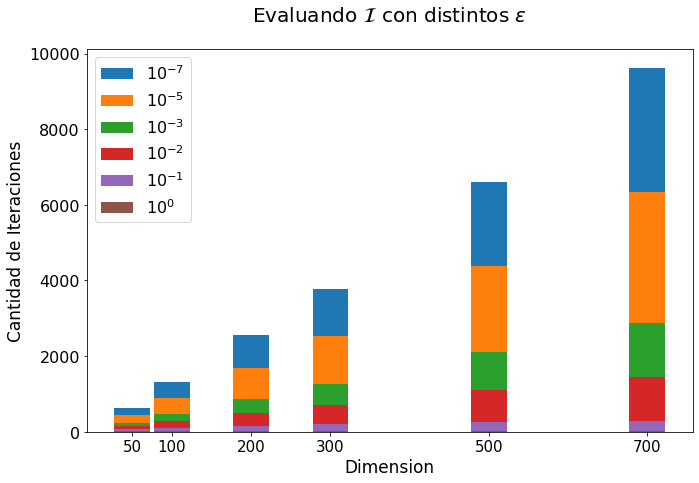

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 

#promedios = [[18.53, 75.08, 153.56, 237.38, 437.09, 632.89], [20.21, 113.18, 274.39, 474.95, 888.64, 1303.91], [21.85, 164.3, 497.31, 856.0, 1698.15, 2546.43], [22.63, 203.37, 713.35, 1263.74, 2521.37, 3774.08], [23.86, 252.34, 1112.38, 2102.55, 4385.6, 6617.07], [24.04, 288.34, 1455.3, 2873.44, 6352.35, 9629.11]]

plt.rcParams["figure.figsize"] = (10,7)
plt.rcParams["font.size"] = 16


stops = ['$10^{0}$', '$10^{-1}$', '$10^{-2}$', '$10^{-3}$', '$10^{-5}$', '$10^{-7}$']
x = [50,100,200,300,500,700]
y = np.random.uniform(2, 7, len(x))

for k in range(6):
  hago_array = [promedios[i][5-k] for i in range(6)]
  plt.bar(x, hago_array, label = stops[5-k], width = 45)


plt.xticks(x, x, size = 15)
plt.xlabel("Dimension", size = 17)
plt.ylabel("Cantidad de Iteraciones", size = 17)
plt.title('Evaluando $\mathcal{I}$ con distintos $\\varepsilon$\n', size = 20)
plt.legend()

plt.tight_layout()

plt.show()